## IMPORTS

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output
import time
from os.path  import join
import itertools
import math
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

### EDA

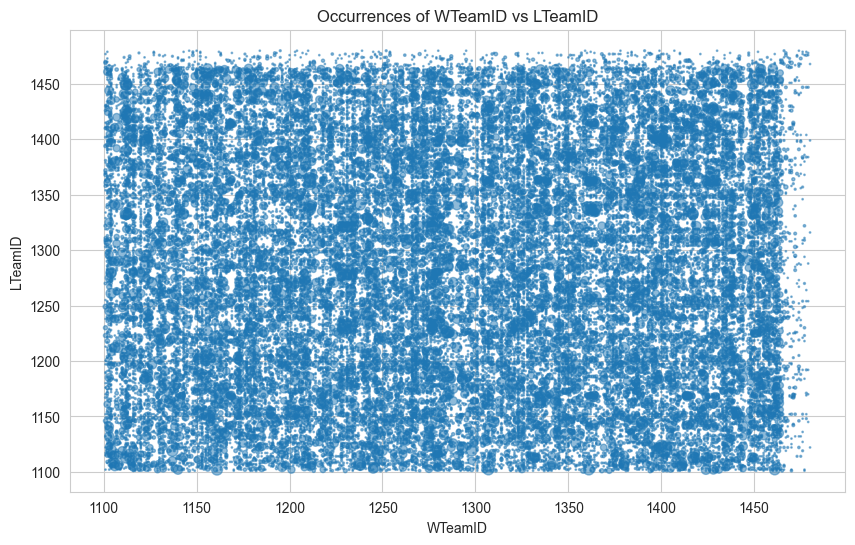

In [38]:
men_scores_compact = pd.read_csv("../../data/MRegularSeasonCompactResults.csv")
men_plays = men_scores_compact.drop(columns=['Season', 'DayNum', 'WScore', 'LScore', 'WLoc', 'NumOT'])
occurrences = men_plays.groupby(['WTeamID', 'LTeamID']).size().reset_index(name='count')
plt.figure(figsize=(10, 6))
plt.scatter(occurrences['WTeamID'], occurrences['LTeamID'], s=occurrences['count'], alpha=0.5)
plt.xlabel('WTeamID')
plt.ylabel('LTeamID')
plt.title('Occurrences of WTeamID vs LTeamID')
plt.show()

    LossStreak  WinProbability  NumGames
0            0        0.563760    192000
1            1        0.500610     83670
2            2        0.448105     41738
3            3        0.411762     23006
4            4        0.372643     13525
..         ...             ...       ...
59          59        0.000000         1
60          60        0.000000         1
61          61        0.000000         1
62          62        0.000000         1
63          63        1.000000         1

[64 rows x 3 columns]


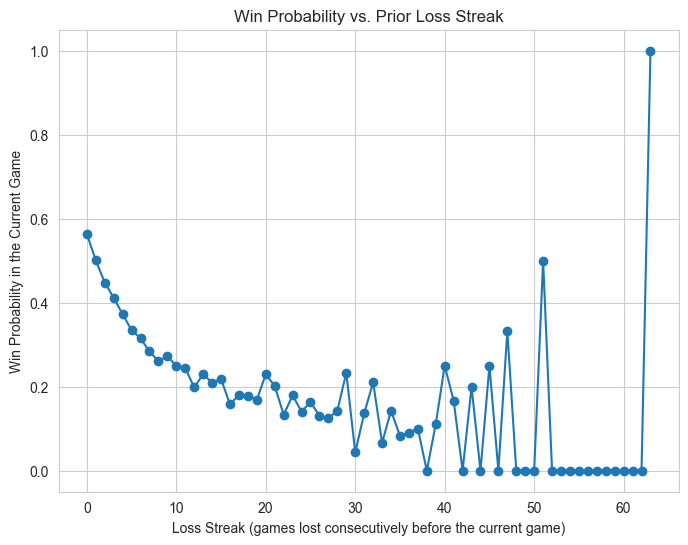

In [39]:
df = pd.read_csv("../../data/MRegularSeasonCompactResults.csv")
wins = df[['Season', 'DayNum', 'WTeamID']].copy()
wins.columns = ['Season', 'DayNum', 'TeamID']
wins['Result'] = 1
losses = df[['Season', 'DayNum', 'LTeamID']].copy()
losses.columns = ['Season', 'DayNum', 'TeamID']
losses['Result'] = 0
games = pd.concat([wins, losses], ignore_index=True)
games = games.sort_values(['TeamID', 'Season', 'DayNum']).reset_index(drop=True)

def compute_loss_streak(results):
    streak = 0
    streaks = []
    for r in results:
        streaks.append(streak)
        if r == 0:
            streak += 1
        else:                   streak = 0
    return streaks

games['LossStreak'] = games.groupby('TeamID')['Result'].transform(compute_loss_streak)
streak_summary = games.groupby('LossStreak')['Result'].agg(['mean', 'count']).reset_index()
streak_summary.rename(columns={'mean': 'WinProbability', 'count': 'NumGames'}, inplace=True)
print(streak_summary)
plt.figure(figsize=(8, 6))
plt.plot(streak_summary['LossStreak'], streak_summary['WinProbability'], marker='o')
plt.xlabel("Loss Streak (games lost consecutively before the current game)")
plt.ylabel("Win Probability in the Current Game")
plt.title("Win Probability vs. Prior Loss Streak")
plt.grid(True)
plt.show()

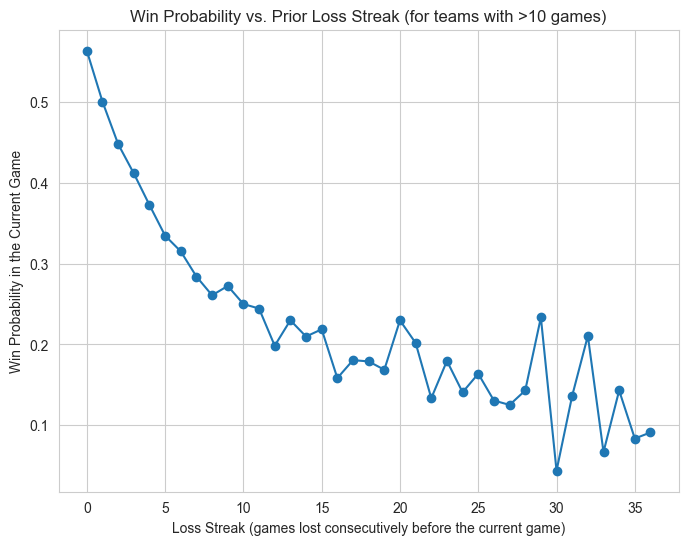

In [40]:
streak_summary = streak_summary[streak_summary['NumGames'] >10]
plt.figure(figsize=(8, 6))
plt.plot(streak_summary['LossStreak'], streak_summary['WinProbability'], marker='o')
plt.xlabel("Loss Streak (games lost consecutively before the current game)")
plt.ylabel("Win Probability in the Current Game")
plt.title("Win Probability vs. Prior Loss Streak (for teams with >10 games)")
plt.grid(True)
plt.show()

First 5 rows of the dataset:
   Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT
0    1985      20     1228      81     1328      64    N      0
1    1985      25     1106      77     1354      70    H      0
2    1985      25     1112      63     1223      56    H      0
3    1985      25     1165      70     1432      54    H      0
4    1985      25     1192      86     1447      74    H      0

Count of non-neutral games by winning location:
WLoc
H    113359
A     58899
Name: count, dtype: int64

Percentage of wins by winning location:
WLoc
H    65.81
A    34.19
Name: count, dtype: float64

Home team win rate (non-neutral games): 65.81%

Average margin of victory by winning location:
WLoc
A     9.483743
H    13.616775
Name: Margin, dtype: float64


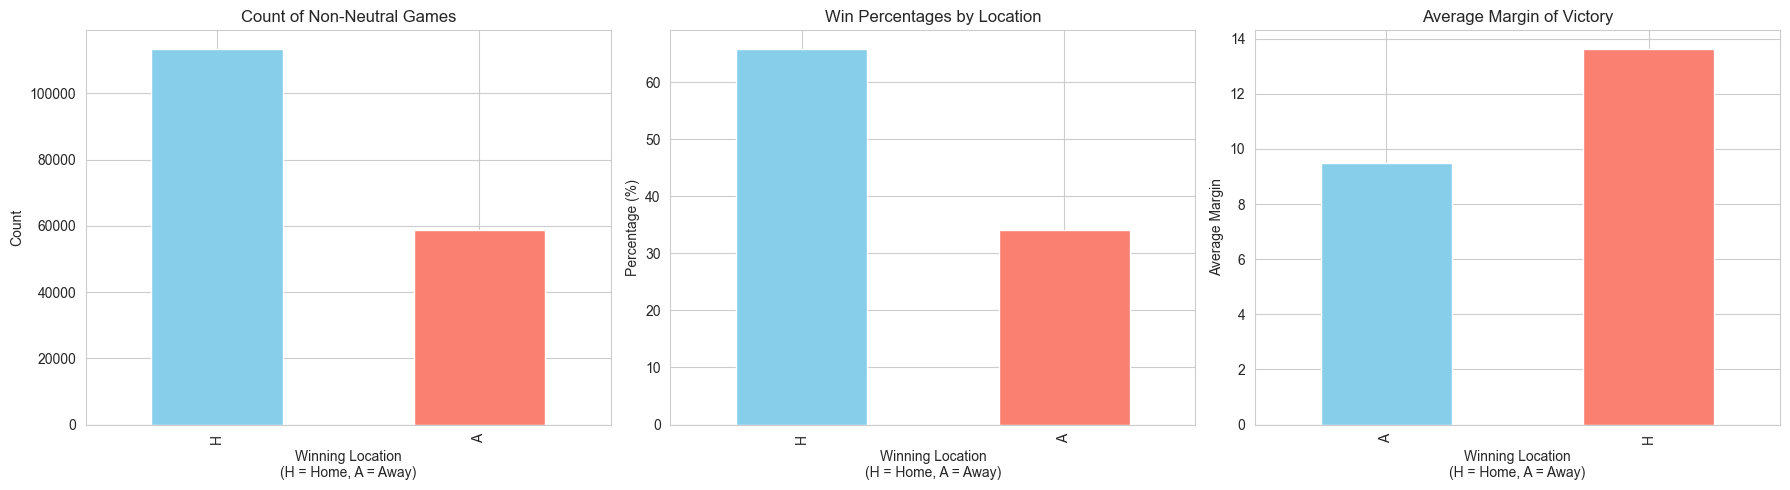

In [41]:
print("First 5 rows of the dataset:")
print(df.head())
df_non_neutral = df[df['WLoc'] != 'N'].copy()
location_counts = df_non_neutral['WLoc'].value_counts()
print("\nCount of non-neutral games by winning location:")
print(location_counts)
total_non_neutral = location_counts.sum()
win_percentages = (location_counts / total_non_neutral * 100).round(2)
print("\nPercentage of wins by winning location:")
print(win_percentages)
home_win_rate = win_percentages.get('H', 0)
print(f"\nHome team win rate (non-neutral games): {home_win_rate:.2f}%")
df_non_neutral['Margin'] = df_non_neutral['WScore'] - df_non_neutral['LScore']
margin_by_loc = df_non_neutral.groupby('WLoc')['Margin'].mean()
print("\nAverage margin of victory by winning location:")
print(margin_by_loc)
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
location_counts.plot(kind='bar', ax=ax[0], color=['skyblue', 'salmon'])
ax[0].set_title("Count of Non-Neutral Games")
ax[0].set_xlabel("Winning Location\n(H = Home, A = Away)")
ax[0].set_ylabel("Count")
win_percentages.plot(kind='bar', ax=ax[1], color=['skyblue', 'salmon'])
ax[1].set_title("Win Percentages by Location")
ax[1].set_xlabel("Winning Location\n(H = Home, A = Away)")
ax[1].set_ylabel("Percentage (%)")
margin_by_loc.plot(kind='bar', ax=ax[2], color=['skyblue', 'salmon'])
ax[2].set_title("Average Margin of Victory")
ax[2].set_xlabel("Winning Location\n(H = Home, A = Away)")
ax[2].set_ylabel("Average Margin")
plt.tight_layout()
plt.show()

First 5 rows of the detailed results dataset:
   Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT  WFGM  WFGA  \
0    2003      10     1104      68     1328      62    N      0    27    58   
1    2003      10     1272      70     1393      63    N      0    26    62   
2    2003      11     1266      73     1437      61    N      0    24    58   
3    2003      11     1296      56     1457      50    N      0    18    38   
4    2003      11     1400      77     1208      71    N      0    30    61   

   ...  LFGA3  LFTM  LFTA  LOR  LDR  LAst  LTO  LStl  LBlk  LPF  
0  ...     10    16    22   10   22     8   18     9     2   20  
1  ...     24     9    20   20   25     7   12     8     6   16  
2  ...     26    14    23   31   22     9   12     2     5   23  
3  ...     22     8    15   17   20     9   19     4     3   23  
4  ...     16    17    27   21   15    12   10     7     1   14  

[5 rows x 34 columns]

Descriptive statistics for winners' shot attempts:
count   

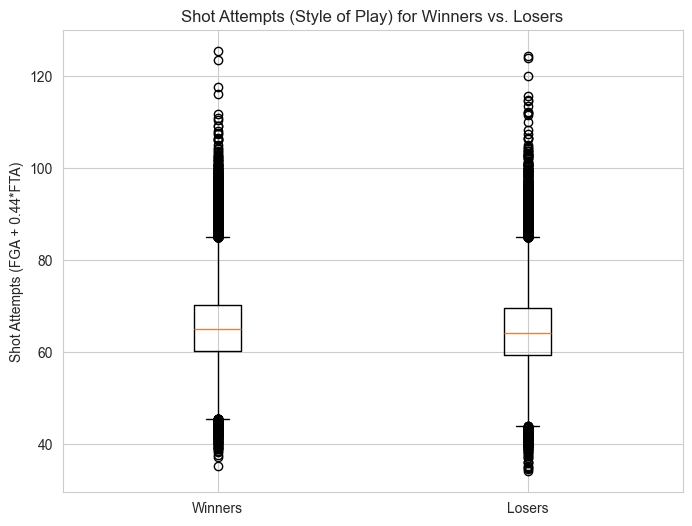

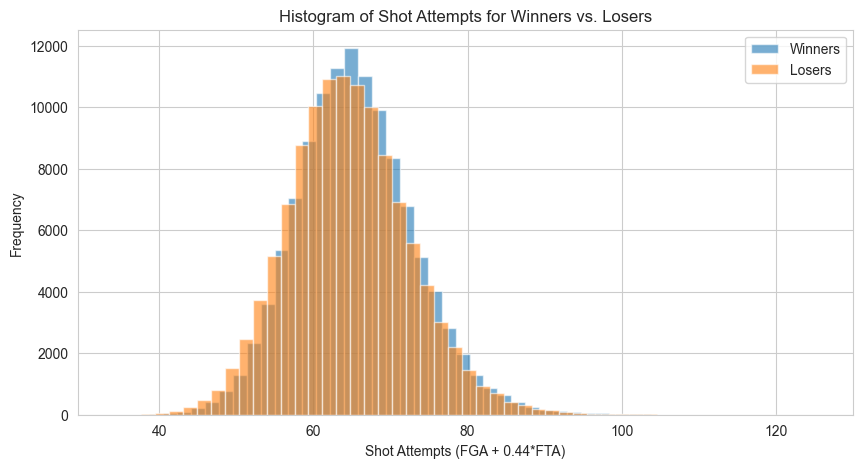

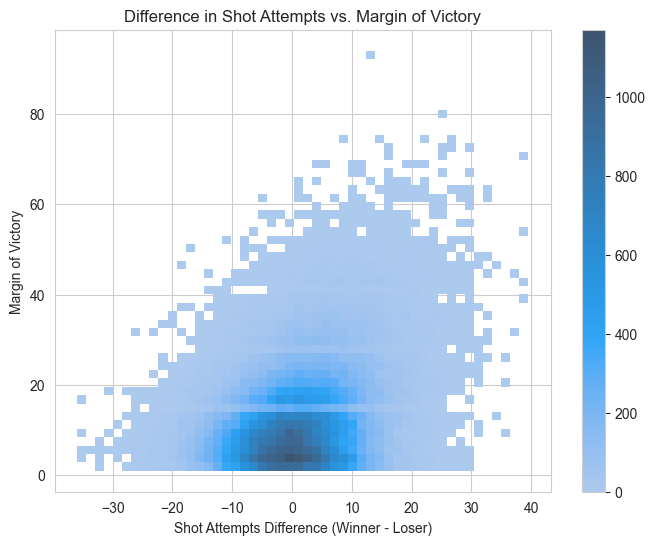


Correlation between shot attempt difference and margin of victory: 0.26


In [42]:
df = pd.read_csv('../../data/MRegularSeasonDetailedResults.csv')
print("First 5 rows of the detailed results dataset:")
print(df.head())
df['W_Attempts'] = df['WFGA'] + 0.44 * df['WFTA']
df['L_Attempts'] = df['LFGA'] + 0.44 * df['LFTA']
print("\nDescriptive statistics for winners' shot attempts:")
print(df['W_Attempts'].describe())
print("\nDescriptive statistics for losers' shot attempts:")
print(df['L_Attempts'].describe())
fig, ax = plt.subplots(figsize=(8, 6))
data = [df['W_Attempts'], df['L_Attempts']]
ax.boxplot(data, labels=['Winners', 'Losers'])
ax.set_title("Shot Attempts (Style of Play) for Winners vs. Losers")
ax.set_ylabel("Shot Attempts (FGA + 0.44*FTA)")
plt.show()
plt.figure(figsize=(10, 5))
plt.hist(df['W_Attempts'], bins=50, alpha=0.6, label='Winners')
plt.hist(df['L_Attempts'], bins=50, alpha=0.6, label='Losers')
plt.title("Histogram of Shot Attempts for Winners vs. Losers")
plt.xlabel("Shot Attempts (FGA + 0.44*FTA)")
plt.ylabel("Frequency")
plt.legend()
plt.show()
df['Margin'] = df['WScore'] - df['LScore']
df['Attempt_Diff'] = df['W_Attempts'] - df['L_Attempts']
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Attempt_Diff', y='Margin', bins=50, cbar=True)
plt.title("Difference in Shot Attempts vs. Margin of Victory")
plt.xlabel("Shot Attempts Difference (Winner - Loser)")
plt.ylabel("Margin of Victory")
plt.show()
correlation = df['Attempt_Diff'].corr(df['Margin'])
print(f"\nCorrelation between shot attempt difference and margin of victory: {correlation:.2f}")

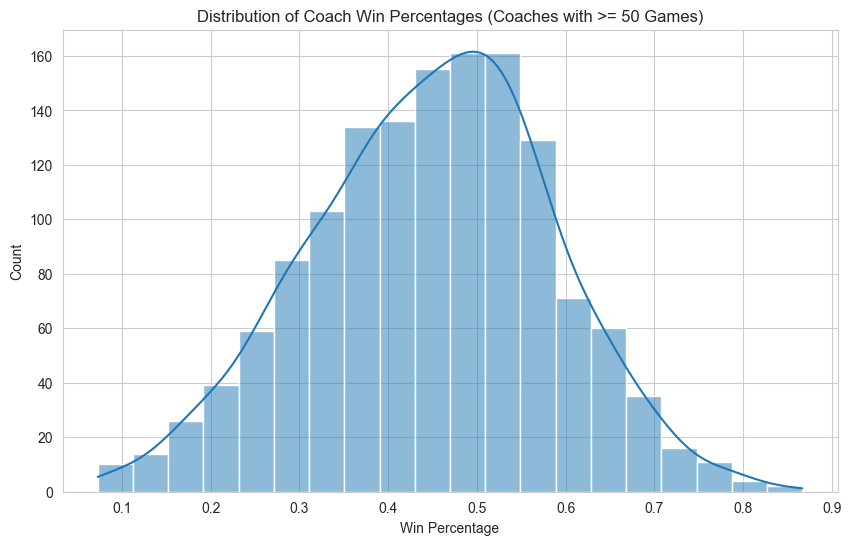

Win percentages by season type:
      is_first_season   games    wins   win_pct
0        First Season   43357   18171  0.419102
1  Subsequent Seasons  340235  173625  0.510309


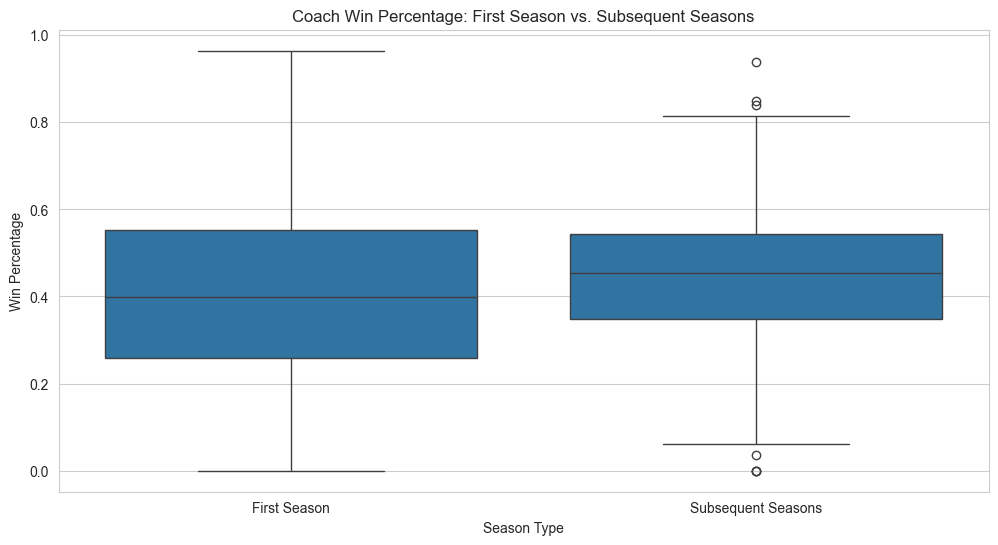

In [43]:
coaches = pd.read_csv('../../data/MTeamCoaches.csv')
games = pd.read_csv('../../data/MRegularSeasonCompactResults.csv')

winners = games[['Season', 'DayNum', 'WTeamID']].copy()
winners.rename(columns={'WTeamID': 'TeamID'}, inplace=True)
winners['Outcome'] = 1

losers = games[['Season', 'DayNum', 'LTeamID']].copy()
losers.rename(columns={'LTeamID': 'TeamID'}, inplace=True)
losers['Outcome'] = 0

coach_games = pd.concat([winners, losers], ignore_index=True)
merged = pd.merge(coach_games, coaches, on=['Season', 'TeamID'], how='left')
merged = merged[(merged['DayNum'] >= merged['FirstDayNum']) & (merged['DayNum'] <= merged['LastDayNum'])]
coach_performance = merged.groupby('CoachName').agg(
    games_coached=('Outcome', 'count'),
    wins=('Outcome', 'sum')
).reset_index()
coach_performance['win_pct'] = coach_performance['wins'] / coach_performance['games_coached']
min_games = 50
coach_performance_filtered = coach_performance[coach_performance['games_coached'] >= min_games]

plt.figure(figsize=(10, 6))
sns.histplot(coach_performance_filtered['win_pct'], bins=20, kde=True)
plt.xlabel('Win Percentage')
plt.title(f'Distribution of Coach Win Percentages (Coaches with >= {min_games} Games)')
plt.show()

first_season = merged.groupby('CoachName')['Season'].min().reset_index().rename(columns={'Season': 'first_season'})
merged = pd.merge(merged, first_season, on='CoachName', how='left')
merged['is_first_season'] = np.where(merged['Season'] == merged['first_season'], 'First Season', 'Subsequent Seasons')
first_season_stats = merged.groupby('is_first_season').agg(
    games=('Outcome', 'count'),
    wins=('Outcome', 'sum')
).reset_index()
first_season_stats['win_pct'] = first_season_stats['wins'] / first_season_stats['games']
print("Win percentages by season type:")
print(first_season_stats)
coach_season_win = merged.groupby(['CoachName', 'is_first_season']).agg(
    games_coached=('Outcome', 'count'),
    wins=('Outcome', 'sum')
).reset_index()
coach_season_win['win_pct'] = coach_season_win['wins'] / coach_season_win['games_coached']

plt.figure(figsize=(12, 6))
sns.boxplot(x='is_first_season', y='win_pct', data=coach_season_win)
plt.xlabel('Season Type')
plt.ylabel('Win Percentage')
plt.title('Coach Win Percentage: First Season vs. Subsequent Seasons')
plt.show()

In [44]:
folder = "../../data/"
mteamcoaches = pd.read_csv(folder + "MTeamCoaches.csv")
mregularseasondetailedresults = pd.read_csv(folder + "MRegularSeasonDetailedResults.csv")
mregularseasoncompactresults = pd.read_csv(folder + "MRegularSeasonCompactResults.csv")
mncaatourneycompactresults = pd.read_csv(folder + "MNCAATourneyCompactResults.csv")
games_df = pd.concat([mregularseasoncompactresults, mncaatourneycompactresults])
winners_coaches = games_df.merge(mteamcoaches, left_on=["Season", "WTeamID"], right_on=["Season", "TeamID"])
winners_coaches = winners_coaches[(winners_coaches['DayNum'] >= winners_coaches['FirstDayNum']) & (
            winners_coaches['DayNum'] <= winners_coaches['LastDayNum'])]
winners_coaches = winners_coaches[['CoachName', 'WScore', 'WLoc', 'Season']].rename(columns={'WScore': 'Score'})
winners_coaches['Win'] = 1
winners_coaches['IsHome'] = winners_coaches['WLoc'] == 'H'
winners_coaches['IsAway'] = winners_coaches['WLoc'] == 'A'
winners_coaches['IsNeutral'] = winners_coaches['WLoc'] == 'N'
winners_coaches['IsHome'] = winners_coaches['IsHome'].astype(int)
winners_coaches['IsAway'] = winners_coaches['IsAway'].astype(int)
winners_coaches['IsNeutral'] = winners_coaches['IsNeutral'].astype(int)
losers_coaches = mregularseasoncompactresults.merge(mteamcoaches, left_on=["Season", "LTeamID"], right_on=["Season", "TeamID"])
losers_coaches = losers_coaches[(losers_coaches['DayNum'] >= losers_coaches['FirstDayNum']) & (losers_coaches['DayNum'] <= losers_coaches['LastDayNum'])]
losers_coaches = losers_coaches[['CoachName', 'LScore', 'WLoc', 'Season']].rename(columns={'LScore': 'Score'})
losers_coaches['Win'] = 0
losers_coaches['IsHomeL'] = losers_coaches['WLoc'] == 'A'
losers_coaches['IsAwayL'] = losers_coaches['WLoc'] == 'H'
losers_coaches['IsNeutralL'] = losers_coaches['WLoc'] == 'N'
losers_coaches['IsHomeL'] = losers_coaches['IsHomeL'].astype(int)
losers_coaches['IsAwayL'] = losers_coaches['IsAwayL'].astype(int)
losers_coaches['IsNeutralL'] = losers_coaches['IsNeutralL'].astype(int)
all_scores_coaches = pd.concat([winners_coaches, losers_coaches])
coach_stats = all_scores_coaches.groupby('CoachName').agg(
    mean_score=('Score', 'mean'),  # Średnia punktów
    sum_score=('Score', 'sum'),    # Suma punktów
    num_games=('Score', 'count'),  # Liczba meczów
    num_wins=('Win', 'sum'),       # Liczba zwycięstw
    num_home_lost=('IsHomeL', 'sum'),
    num_home_wins=('IsHome', 'sum'),
    num_away_lost=('IsAwayL', 'sum'),
    num_away_wins=('IsAway', 'sum'),
    num_neutral_lost=('IsNeutralL', 'sum'),  # Liczba meczów neutralnych
    num_neutral_wins=('IsNeutral', 'sum'),   # Liczba wygranych neutralnych
    first_season=('Season', 'min'),  # Pierwszy sezon trenera
    last_season=('Season', 'max')    # Ostatni sezon trenera
).reset_index()
coach_stats
coach_stats['home_win_pct'] = np.where(
    (coach_stats['num_home_lost'] + coach_stats['num_home_wins']) == 0,
    0,  # wartość domyślna, gdy mianownik wynosi 0
    coach_stats['num_home_wins'] / (coach_stats['num_home_lost'] + coach_stats['num_home_wins'])
)
coach_stats['away_win_pct'] = np.where((coach_stats['num_away_lost'] + coach_stats['num_away_wins']) == 0, 0,
                                       coach_stats['num_away_wins'] / (
                                                   coach_stats['num_away_lost'] + coach_stats['num_away_wins']))
coach_stats['win_pct'] = coach_stats['num_wins'] / coach_stats['num_games']
coach_stats['neutral_win_pct'] = np.where((coach_stats['num_neutral_lost'] + coach_stats['num_neutral_wins']) == 0, 0,
                                          coach_stats['num_neutral_wins'] / (
                                                      coach_stats['num_neutral_lost'] + coach_stats[
                                                  'num_neutral_wins']))
coach_stats = coach_stats.fillna(0)
coach_stats = coach_stats.sort_values(by='num_wins', ascending=False)

# ELO parameters
INITIAL_ELO = 1500  # Initial ELO rating
K = 32  # Weight of each game

# Dictionary to store ELO ratings for each coach
elo_ratings = {}

# Probability of winning for a given rating difference
def expected_score(rating_A, rating_B):
    return 1 / (1 + 10 ** ((rating_B - rating_A) / 400))

# Update ELO ratings based on the outcome of a game
def update_elo(winner, loser):
    global elo_ratings
    Ra = elo_ratings.get(winner, INITIAL_ELO)
    Rb = elo_ratings.get(loser, INITIAL_ELO)

    Pa = expected_score(Ra, Rb)
    Pb = expected_score(Rb, Ra)

    elo_ratings[winner] = Ra + K * (1 - Pa)
    elo_ratings[loser] = Rb + K * (0 - Pb)
matchups = games_df.merge(
    mteamcoaches, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left'
).rename(columns={'CoachName': 'WinningCoach'}).merge(
    mteamcoaches, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left'
).rename(columns={'CoachName': 'LosingCoach'})
for _, row in matchups.iterrows():
    winner = row['WinningCoach']
    loser = row['LosingCoach']

    if pd.notna(winner) and pd.notna(loser):
        update_elo(winner, loser)

elo_df = pd.DataFrame(list(elo_ratings.items()), columns=['CoachName', 'EloRating']).sort_values(by='EloRating', ascending=False)
print("ELO ratings for coaches:")
print(elo_df)
coach_stats = coach_stats.merge(elo_df, on='CoachName', how='left')
print("Coach statistics with ELO ratings:")
coach_stats

ELO ratings for coaches:
           CoachName    EloRating
1158      dan_hurley  2153.951889
1318       nate_oats  2079.597712
632       jay_wright  2073.491043
1514     jon_scheyer  2063.222127
561     john_beilein  2054.404381
...              ...          ...
330   marshall_emery  1087.072746
918       ed_daniels  1081.755056
44       mark_reiner  1080.127416
180      howie_evans  1067.642871
764   harold_blevins  1054.406091

[1621 rows x 2 columns]
Coach statistics with ELO ratings:


,CoachName,mean_score,sum_score,num_games,num_wins,num_home_lost,num_home_wins,num_away_lost,num_away_wins,num_neutral_lost,num_neutral_wins,first_season,last_season,home_win_pct,away_win_pct,win_pct,neutral_win_pct,EloRating
0,mike_krzyzewski,82.103421,105585,1286,1064,54.0,533.0,127.0,246.0,41.0,285.0,1985,2022,0.908007,0.659517,0.827372,0.874233,2048.675955
1,jim_boeheim,76.064567,96602,1270,920,123.0,551.0,168.0,211.0,59.0,158.0,1985,2023,0.817507,0.556728,0.724409,0.728111,1964.648442
2,roy_williams,82.219314,91099,1108,872,58.0,424.0,126.0,223.0,52.0,225.0,1989,2021,0.879668,0.638968,0.787004,0.812274,2051.314530
3,john_calipari,77.141026,84238,1092,849,60.0,469.0,134.0,215.0,49.0,165.0,1989,2025,0.886578,0.616046,0.777473,0.771028,1987.680829
4,bob_huggins,75.173333,90208,1200,844,100.0,480.0,202.0,210.0,54.0,154.0,1985,2023,0.827586,0.509709,0.703333,0.740385,1841.213563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,steve_beason,55.423077,1441,26,0,8.0,0.0,16.0,0.0,2.0,0.0,1995,1995,0.000000,0.000000,0.000000,0.000000,1231.214286
1616,jim_harrick_jr,64.285714,450,7,0,3.0,0.0,4.0,0.0,0.0,0.0,1992,1992,0.000000,0.000000,0.000000,0.000000,1341.931884
1617,thomas_dean,68.200000,341,5,0,0.0,0.0,5.0,0.0,0.0,0.0,1985,1985,0.000000,0.000000,0.000000,0.000000,1275.546906
1618,denis_willens,65.916667,791,12,0,4.0,0.0,7.0,0.0,1.0,0.0,1988,1988,0.000000,0.000000,0.000000,0.000000,1319.073109


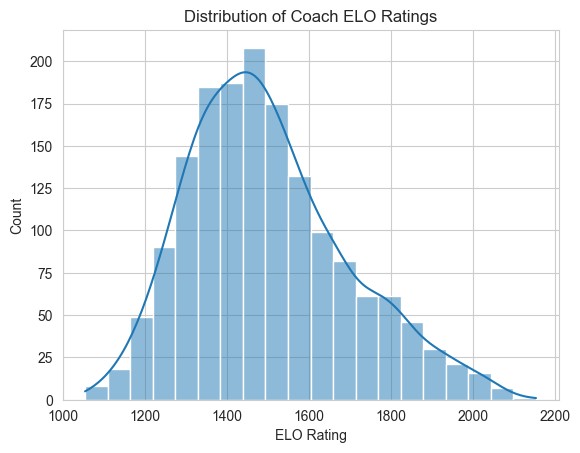

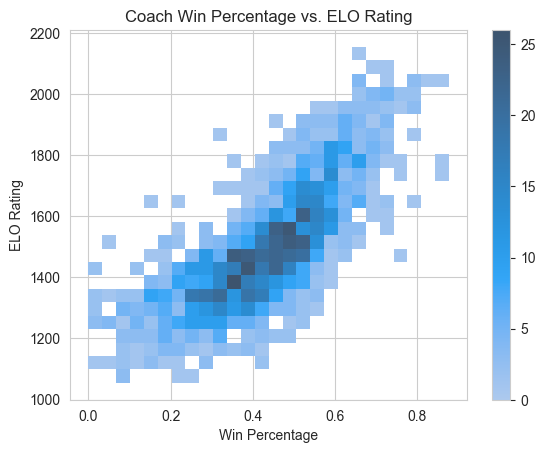

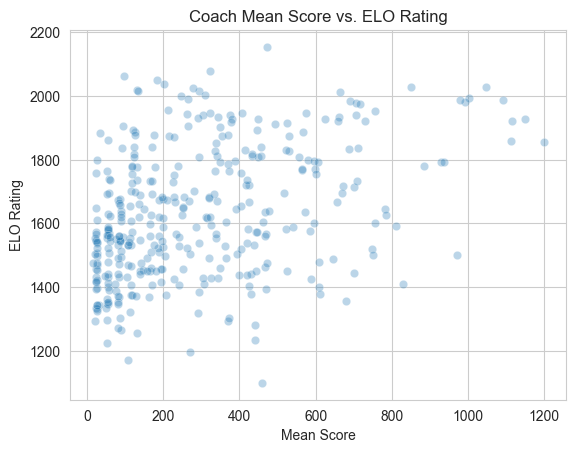

In [45]:
sns.histplot(coach_stats['EloRating'], bins=20, kde=True)
plt.xlabel('ELO Rating')
plt.title('Distribution of Coach ELO Ratings')
plt.show()
sns.histplot(data=coach_stats, y='EloRating', x='win_pct', cbar=True)
plt.ylabel('ELO Rating')
plt.xlabel('Win Percentage')
plt.title('Coach Win Percentage vs. ELO Rating')
plt.show()
sns.scatterplot(data=coach_stats[coach_stats['last_season']==2025], y='EloRating', x='num_games', alpha=0.3)
plt.ylabel('ELO Rating')
plt.xlabel('Mean Score')
plt.title('Coach Mean Score vs. ELO Rating')
plt.show()

In [46]:
games_df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0
...,...,...,...,...,...,...,...,...
2513,2024,146,1301,76,1181,64,N,0
2514,2024,146,1345,72,1397,66,N,0
2515,2024,152,1163,86,1104,72,N,0
2516,2024,152,1345,63,1301,50,N,0


     TeamID    EloRating
165    1163  2122.020389
98     1314  2044.036087
209    1222  2016.536112
87     1437  1998.272025
112    1276  1986.310011
..      ...          ...
284    1164   991.423876
129    1341   975.920482
178    1271   973.427566
315    1115   946.408221
116    1290   780.774946

[380 rows x 2 columns]


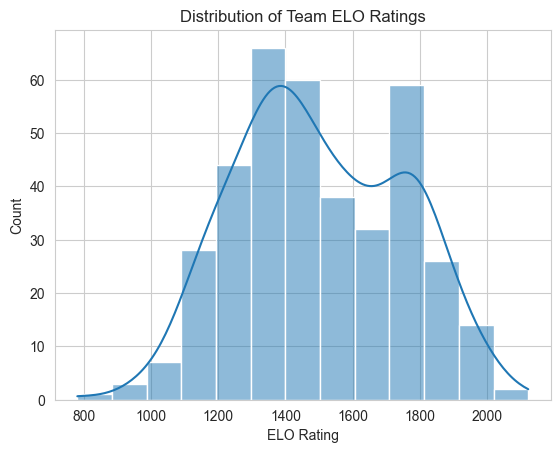

In [47]:
elo_ratings = {}
for _, row in games_df.iterrows():
    winner = row['WTeamID']
    loser = row['LTeamID']

    if pd.notna(winner) and pd.notna(loser):
        update_elo(winner, loser)

teams_elo_df = pd.DataFrame(list(elo_ratings.items()), columns=['TeamID', 'EloRating']).sort_values(by='EloRating', ascending=False)
print(teams_elo_df)
sns.histplot(teams_elo_df['EloRating'], kde=True)
plt.xlabel('ELO Rating')
plt.title('Distribution of Team ELO Ratings')
plt.show()

In [48]:
games = pd.read_csv('../../data/MRegularSeasonCompactResults.csv')
teams = pd.read_csv('../../data/MTeams.csv')
team_names = dict(zip(teams['TeamID'], teams['TeamName']))

games['TeamA'] = games[['WTeamID', 'LTeamID']].min(axis=1)
games['TeamB'] = games[['WTeamID', 'LTeamID']].max(axis=1)

pair_counts = games.groupby(['TeamA', 'TeamB']).size().reset_index(name='games_played')
top_pairs = pair_counts.sort_values('games_played', ascending=False).head(10)
top_pairs['TeamAName'] = top_pairs['TeamA'].map(team_names)
top_pairs['TeamBName'] = top_pairs['TeamB'].map(team_names)
print("Top 10 pairs of teams that have played the most games together:")
print(top_pairs[['TeamAName', 'TeamBName', 'games_played']])


Top 10 pairs of teams that have played the most games together:
         TeamAName       TeamBName  games_played
14680      Gonzaga    St Mary's CA           103
17815       Kansas       Kansas St            99
4972      Bucknell          Lehigh            98
25440   Pepperdine       San Diego            95
14808    Grambling     TX Southern            95
26852  Santa Clara    St Mary's CA            95
10979         Duke  North Carolina            94
4490       Bradley           Drake            94
19946        Maine         Vermont            94
12409    Fairfield      St Peter's            94


### SEEDS

Win counts for seeds (teams made it into the turney) vs other seeded teams in RegularSeason


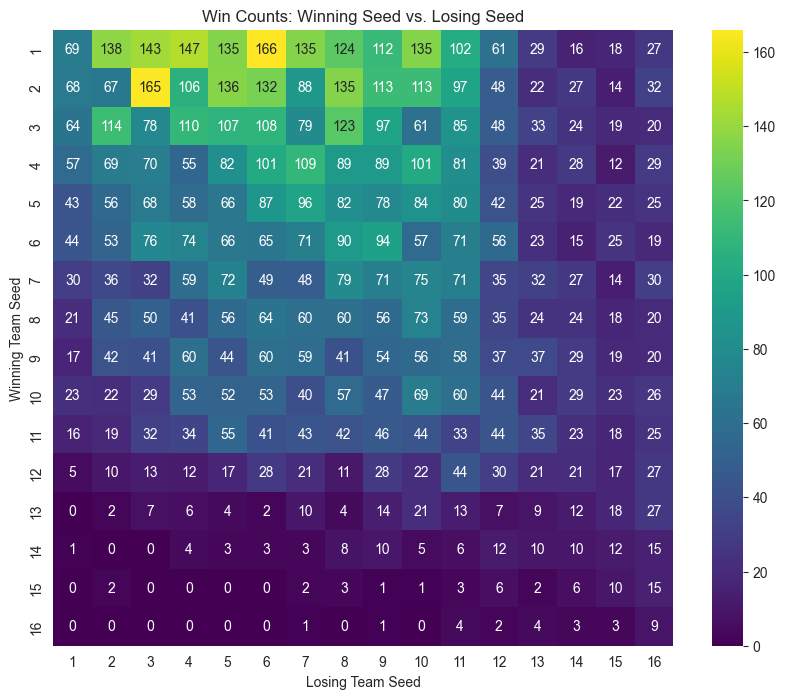

In [49]:
data_path = '../../data'

# The Basics ------------------------------------------------------------------------
# Men
MTeams = pd.read_csv(join(data_path, 'MTeams.csv'))
MSeasons = pd.read_csv(join(data_path, 'MSeasons.csv'))
MNCAATourneySeeds = pd.read_csv(join(data_path, 'MNCAATourneySeeds.csv'))
MRegularSeasonCompactResults = pd.read_csv(join(data_path, 'MRegularSeasonCompactResults.csv'))
MNCAATourneyCompactResults = pd.read_csv(join(data_path, 'MNCAATourneyCompactResults.csv'))
# Women
WTeams = pd.read_csv(join(data_path, 'WTeams.csv'))
WSeasons = pd.read_csv(join(data_path, 'WSeasons.csv'))
WNCAATourneySeeds = pd.read_csv(join(data_path, 'WNCAATourneySeeds.csv'))
WRegularSeasonCompactResults = pd.read_csv(join(data_path, 'WRegularSeasonCompactResults.csv'))
WNCAATourneyCompactResults = pd.read_csv(join(data_path, 'WNCAATourneyCompactResults.csv'))
# Other
SampleSubmissionStage1 = pd.read_csv(join(data_path, 'SampleSubmissionStage1.csv'))
SampleSubmissionStage2 = pd.read_csv(join(data_path, 'SampleSubmissionStage2.csv'))
SeedBenchmarkStage1 = pd.read_csv(join(data_path, 'SeedBenchmarkStage1.csv'))

# Team Box Scores ------------------------------------------------------------------------
# Men
MRegularSeasonDetailedResults = pd.read_csv(join(data_path, 'MRegularSeasonDetailedResults.csv'))
MNCAATourneyDetailedResults = pd.read_csv(join(data_path, 'MNCAATourneyDetailedResults.csv'))
# Women
WRegularSeasonDetailedResults = pd.read_csv(join(data_path, 'WRegularSeasonDetailedResults.csv'))
WNCAATourneyDetailedResults = pd.read_csv(join(data_path, 'WNCAATourneyDetailedResults.csv'))

# Geography ------------------------------------------------------------------------
# All
Cities = pd.read_csv(join(data_path, 'Cities.csv'))
Conferences = pd.read_csv(join(data_path, 'Conferences.csv'))
# Men
MGameCities = pd.read_csv(join(data_path, 'MGameCities.csv'))
# Women
WGameCities = pd.read_csv(join(data_path, 'WGameCities.csv'))

# Public Rankings ------------------------------------------------------------------------
# Men
MMasseyOrdinals = pd.read_csv(join(data_path, 'MMasseyOrdinals.csv')) # men only

# Supplements ------------------------------------------------------------------------
# Men
MTeamCoaches = pd.read_csv(join(data_path, 'MTeamCoaches.csv')) # men only
MTeamConferences = pd.read_csv(join(data_path, 'MTeamConferences.csv'))
MConferenceTourneyGames = pd.read_csv(join(data_path, 'MConferenceTourneyGames.csv'))
MSecondaryTourneyTeams = pd.read_csv(join(data_path, 'MSecondaryTourneyTeams.csv'))
MSecondaryTourneyCompactResults = pd.read_csv(join(data_path, 'MSecondaryTourneyCompactResults.csv'))
MTeamSpellings = pd.read_csv(join(data_path, "MTeamSpellings.csv"), encoding='cp1252')
MNCAATourneySlots = pd.read_csv(join(data_path, 'MNCAATourneySlots.csv'))
MNCAATourneySeedRoundSlots = pd.read_csv(join(data_path, 'MNCAATourneySeedRoundSlots.csv')) # men only
# Women
WTeamConferences = pd.read_csv(join(data_path, 'WTeamConferences.csv'))
WConferenceTourneyGames = pd.read_csv(join(data_path, 'WConferenceTourneyGames.csv'))
WSecondaryTourneyTeams = pd.read_csv(join(data_path, 'WSecondaryTourneyTeams.csv'))
WSecondaryTourneyCompactResults = pd.read_csv(join(data_path, 'WSecondaryTourneyCompactResults.csv'))
WTeamSpellings = pd.read_csv(join(data_path, 'WTeamSpellings.csv'), encoding='cp1252')
WNCAATourneySlots = pd.read_csv(join(data_path, 'WNCAATourneySlots.csv'))

# Merge to get the winning team's seed
merged_results = pd.merge(
    MRegularSeasonCompactResults,
    MNCAATourneySeeds[['Season', 'Seed', 'TeamID']],
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID'],
    how='inner'
).rename(columns={'Seed': 'WTeamSeed'}).drop('TeamID', axis=1)

# Merge to get the losing team's seed
RegularSeasonSeedResults = pd.merge(
    merged_results,
    MNCAATourneySeeds[['Season', 'Seed', 'TeamID']],
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID'],
    how='inner'
).rename(columns={'Seed': 'LTeamSeed'}).drop('TeamID', axis=1)

# Extract numeric seed values
RegularSeasonSeedResults['WTeamSeedRaw'] = RegularSeasonSeedResults['WTeamSeed'].str.extract('(\d+)')[0].astype(int)
RegularSeasonSeedResults['LTeamSeedRaw'] = RegularSeasonSeedResults['LTeamSeed'].str.extract('(\d+)')[0].astype(int)

# Create the 16x16 matrix with seed values from 1 to 16
seed_matrix = pd.crosstab(RegularSeasonSeedResults['WTeamSeedRaw'], RegularSeasonSeedResults['LTeamSeedRaw'])
seeds = range(1, 17)
seed_matrix = seed_matrix.reindex(index=seeds, columns=seeds, fill_value=0)

print("Win counts for seeds (teams made it into the turney) vs other seeded teams in RegularSeason")
# If you are in a Jupyter Notebook, simply display the styled DataFrame:

# Plot a heatmap with annotations
plt.figure(figsize=(10, 8))
sns.heatmap(seed_matrix, annot=True, fmt='d', cmap='viridis')
plt.title('Win Counts: Winning Seed vs. Losing Seed')
plt.xlabel('Losing Team Seed')
plt.ylabel('Winning Team Seed')
plt.show()


That means teams who get low number seed and make it into the tournament tend to get matched against teams they won against in the regular season.

Scores from regular season


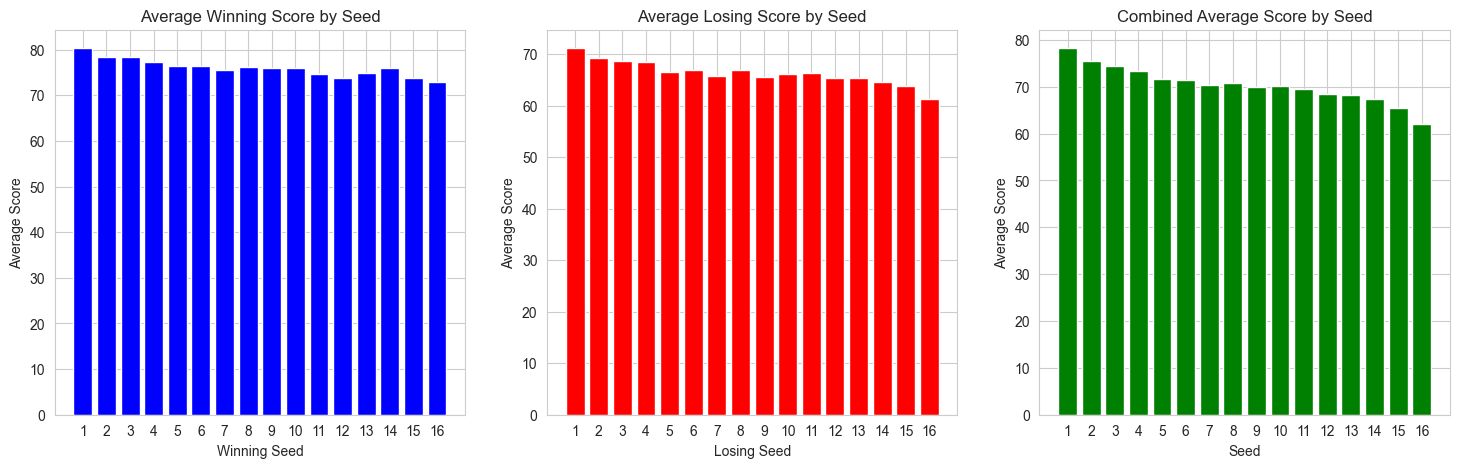

In [50]:
# Compute average score for winning teams grouped by winning seed
avg_win = RegularSeasonSeedResults.groupby('WTeamSeedRaw')['WScore'].mean().sort_index()

# Compute average score for losing teams grouped by losing seed
avg_loss = RegularSeasonSeedResults.groupby('LTeamSeedRaw')['LScore'].mean().sort_index()

# For combined average: combine winning and losing scores into one dataframe.
winning_scores = RegularSeasonSeedResults[['WTeamSeedRaw', 'WScore']].rename(
    columns={'WTeamSeedRaw': 'Seed', 'WScore': 'Score'})
losing_scores = RegularSeasonSeedResults[['LTeamSeedRaw', 'LScore']].rename(
    columns={'LTeamSeedRaw': 'Seed', 'LScore': 'Score'})
combined_scores = pd.concat([winning_scores, losing_scores], ignore_index=True)

avg_combined = combined_scores.groupby('Seed')['Score'].mean().sort_index()

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Winning seeds only
axes[0].bar(avg_win.index, avg_win.values, color='blue')
axes[0].set_title('Average Winning Score by Seed')
axes[0].set_xlabel('Winning Seed')
axes[0].set_ylabel('Average Score')
axes[0].set_xticks(range(1, 17))

# Plot 2: Losing seeds only
axes[1].bar(avg_loss.index, avg_loss.values, color='red')
axes[1].set_title('Average Losing Score by Seed')
axes[1].set_xlabel('Losing Seed')
axes[1].set_ylabel('Average Score')
axes[1].set_xticks(range(1, 17))

# Plot 3: Combined seeds (winning + losing)
axes[2].bar(avg_combined.index, avg_combined.values, color='green')
axes[2].set_title('Combined Average Score by Seed')
axes[2].set_xlabel('Seed')
axes[2].set_ylabel('Average Score')
axes[2].set_xticks(range(1, 17))

print("Scores from regular season")
plt.show()

On average higher scoring teams in regular season are awarded lower seeds.


### Which Teams didn't make it to the tournament?

For year  2010
Max score of team, that did not make it into tourney:  2554
Min score of team, that did not make it into tourney:  1220
Max mean score of team, that did not make it into tourney:  86.08
   Season  TeamID  Score  Score_Mean
0    1985    1106   1719   71.625000
1    1985    1165   1473   61.375000
2    1985    1218   1945   69.464286
3    1985    1307   2020   69.655172
4    1985    1344   1890   65.172414


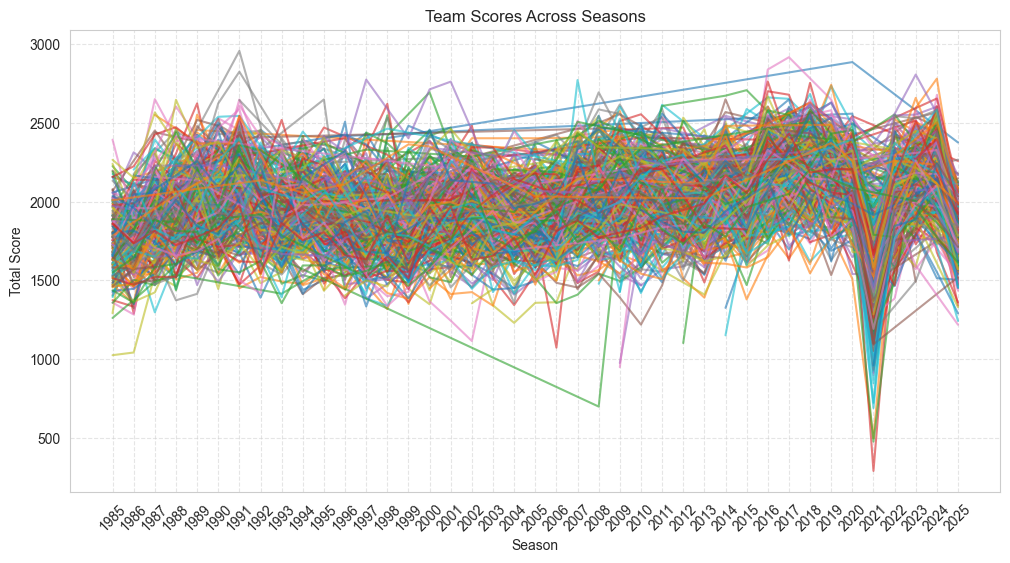

In [51]:
# Find teams that played in the regular season but didn't make the tournament
regular_season_teams = MRegularSeasonCompactResults[['Season', 'WTeamID']].rename(columns={'WTeamID': 'TeamID'})
regular_season_teams = pd.concat(
    [regular_season_teams,
     MRegularSeasonCompactResults[['Season', 'LTeamID']].rename(columns={'LTeamID': 'TeamID'})],
    ignore_index=True
).drop_duplicates()

# Tournament teams
tourney_teams = MNCAATourneySeeds[['Season', 'TeamID']].drop_duplicates()

# Find teams that are in the regular season but not in the tournament
TeamsInRegularSeasonNotInTourney = regular_season_teams.merge(
    tourney_teams, on=['Season', 'TeamID'], how='left', indicator=True
).query('_merge == "left_only"').drop(columns=['_merge'])

# Create a DataFrame with scores when teams won
win_scores = MRegularSeasonCompactResults[['Season', 'WTeamID', 'WScore']].rename(
    columns={'WTeamID': 'TeamID', 'WScore': 'Score'}
)

# Create a DataFrame with scores when teams lost
loss_scores = MRegularSeasonCompactResults[['Season', 'LTeamID', 'LScore']].rename(
    columns={'LTeamID': 'TeamID', 'LScore': 'Score'}
)

# Concatenate the two DataFrames to have one row per team per game
all_scores = pd.concat([win_scores, loss_scores], ignore_index=True)

# Group by Season and TeamID to calculate the total score for each team per season
total_scores = all_scores.groupby(['Season', 'TeamID'])['Score'].sum().reset_index()
mean_scores = all_scores.groupby(['Season', 'TeamID'])['Score'].mean().reset_index()
score_stats = pd.merge(total_scores, mean_scores, on=['Season', 'TeamID'], suffixes=('', '_Mean'))

# Filter for teams that are in TeamsInRegularSeasonNotInTourney
TeamsInRegularSeasonNotInTourney_totals = pd.merge(
    TeamsInRegularSeasonNotInTourney,
    score_stats,
    on=['Season', 'TeamID'],
    how='left'
)

year = 2010
print('For year ', year)
# In case a team has no score (shouldn't happen if they played), fill with 0
TeamsInRegularSeasonNotInTourney_totals['Score'] = TeamsInRegularSeasonNotInTourney_totals['Score'].fillna(0)
print('Max score of team, that did not make it into tourney: ',
      max(TeamsInRegularSeasonNotInTourney_totals['Score'][TeamsInRegularSeasonNotInTourney_totals['Season']==year]))
print('Min score of team, that did not make it into tourney: ',
      min(TeamsInRegularSeasonNotInTourney_totals['Score'][TeamsInRegularSeasonNotInTourney_totals['Season']==year]))
print('Max mean score of team, that did not make it into tourney: ',
      max(TeamsInRegularSeasonNotInTourney_totals['Score_Mean'][TeamsInRegularSeasonNotInTourney_totals['Season']==year]))
print(TeamsInRegularSeasonNotInTourney_totals.head())
# Sort data by Season and TeamID
TeamsInRegularSeasonNotInTourney_totals = TeamsInRegularSeasonNotInTourney_totals.sort_values(['TeamID', 'Season'])

# Create the plot
plt.figure(figsize=(12, 6))

# Plot one line per TeamID
for team_id, team_data in TeamsInRegularSeasonNotInTourney_totals.groupby('TeamID'):
    plt.plot(team_data['Season'], team_data['Score'], label=team_id, alpha=0.6)

# Labels and title
plt.xlabel("Season")
plt.ylabel("Total Score")
plt.title("Team Scores Across Seasons")
plt.xticks(sorted(TeamsInRegularSeasonNotInTourney_totals['Season'].unique()))  # Ensure chronological order
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=45)

# Show the plot
plt.show()

### Which Teams did make it to the tournament?

In [52]:
tourney_teams = MNCAATourneySeeds[['Season', 'TeamID']].drop_duplicates()

# Create a DataFrame with scores when teams won
win_scores = MRegularSeasonCompactResults[['Season', 'WTeamID', 'WScore']].rename(
    columns={'WTeamID': 'TeamID', 'WScore': 'Score'}
)

# Create a DataFrame with scores when teams lost
loss_scores = MRegularSeasonCompactResults[['Season', 'LTeamID', 'LScore']].rename(
    columns={'LTeamID': 'TeamID', 'LScore': 'Score'}
)

# Concatenate the two DataFrames to have one row per team per game
all_scores = pd.concat([win_scores, loss_scores], ignore_index=True)

# Group by Season and TeamID to calculate the total score for each team per season
total_scores = all_scores.groupby(['Season', 'TeamID'])['Score'].sum().reset_index()
mean_scores = all_scores.groupby(['Season', 'TeamID'])['Score'].mean().reset_index()
score_stats = pd.merge(total_scores, mean_scores, on=['Season', 'TeamID'], suffixes=('', '_Mean'))

# Filter for teams that are in TeamsInRegularSeasonNotInTourney
TeamsInRegularSeasonInTourney_totals = pd.merge(
    tourney_teams,
    score_stats,
    on=['Season', 'TeamID'],
    how='left'
)

import matplotlib.pyplot as plt
import seaborn as sns

# Sort data by Season and TeamID
TeamsInRegularSeasonNotInTourney_totals = TeamsInRegularSeasonNotInTourney_totals.sort_values(['TeamID', 'Season'])

year = 2010
print('For year ', year)
# In case a team has no score (shouldn't happen if they played), fill with 0
TeamsInRegularSeasonInTourney_totals['Score'] = TeamsInRegularSeasonInTourney_totals['Score'].fillna(0)
print('Min score of team, that did make it into tourney: ',
      min(TeamsInRegularSeasonInTourney_totals['Score'][TeamsInRegularSeasonInTourney_totals['Season']==year]))
print('Max score of team, that did make it into tourney: ',
      max(TeamsInRegularSeasonInTourney_totals['Score'][TeamsInRegularSeasonInTourney_totals['Season']==year]))
print('Min mean score of team, that did make it into tourney: ',
      min(TeamsInRegularSeasonInTourney_totals['Score_Mean'][TeamsInRegularSeasonInTourney_totals['Season']==year]))
TeamsInRegularSeasonInTourney_totals.head()

For year  2010
Min score of team, that did make it into tourney:  1877
Max score of team, that did make it into tourney:  2780
Min mean score of team, that did make it into tourney:  62.56666666666667


,Season,TeamID,Score,Score_Mean
0,1985,1207,2045,75.740741
1,1985,1210,2198,70.903226
2,1985,1228,2115,68.225806
3,1985,1260,2575,85.833333
4,1985,1374,2279,75.966667


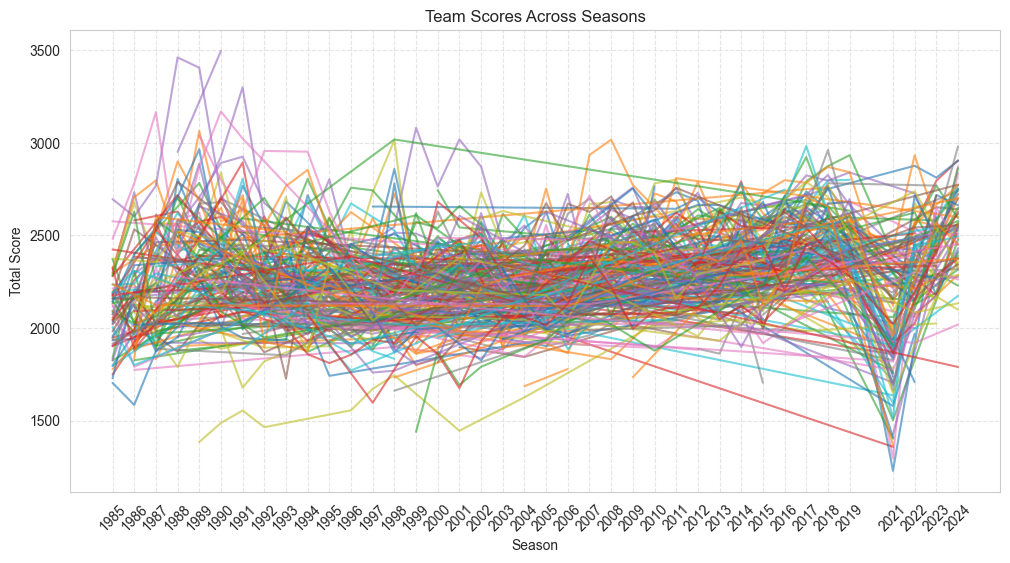

In [53]:
# Create the plot
plt.figure(figsize=(12, 6))
# Plot one line per TeamID
for team_id, team_data in TeamsInRegularSeasonInTourney_totals.groupby('TeamID'):
    plt.plot(team_data['Season'], team_data['Score'], label=team_id, alpha=0.6)
# Labels and title
plt.xlabel("Season")
plt.ylabel("Total Score")
plt.title("Team Scores Across Seasons")
plt.xticks(sorted(TeamsInRegularSeasonInTourney_totals['Season'].unique()))  # Ensure chronological order
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
# Show the plot
plt.show()

There is no clear score boundary from whitch teams are qualified into the tournament. The teams, who qualify then to have larger score on average though. The mechanism for accepting teams during selection sunday aren't known, or at least I haven't found much, but other than the score from regular season conferences should influence this decision.

### Seed impact on winning

In [54]:
merged_results = pd.merge(
    MNCAATourneyCompactResults,
    MNCAATourneySeeds[['Season', 'Seed', 'TeamID']],
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID'],
    how='left'
).rename(columns={'Seed': 'WTeamSeed'}).drop('TeamID', axis=1)

# Merge to get the losing team's seed
TourneySeedResults = pd.merge(
    merged_results,
    MNCAATourneySeeds[['Season', 'Seed', 'TeamID']],
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID'],
    how='left'
).rename(columns={'Seed': 'LTeamSeed'}).drop('TeamID', axis=1)

TourneySeedResults['WTeamSeedRaw'] = TourneySeedResults['WTeamSeed'].str.extract('(\d+)')[0].astype(int)
TourneySeedResults['LTeamSeedRaw'] = TourneySeedResults['LTeamSeed'].str.extract('(\d+)')[0].astype(int)

# Extract the letter prefix from WTeamSeed and LTeamSeed
TourneySeedResults['WTeamSeedPrefix'] = TourneySeedResults['WTeamSeed'].str[0]  # First character
TourneySeedResults['LTeamSeedPrefix'] = TourneySeedResults['LTeamSeed'].str[0]  # First character

# Extract the letter prefix from WTeamSeed and LTeamSeed (useful for looking for play-ins)
TourneySeedResults['WTeamSeedSufix'] = TourneySeedResults['WTeamSeed'].str[-1]  # Last character
TourneySeedResults['LTeamSeedSufix'] = TourneySeedResults['LTeamSeed'].str[-1]  # Last character

TourneySeedResults.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WTeamSeed,LTeamSeed,WTeamSeedRaw,LTeamSeedRaw,WTeamSeedPrefix,LTeamSeedPrefix,WTeamSeedSufix,LTeamSeedSufix
0,1985,136,1116,63,1234,54,N,0,X09,X08,9,8,X,X,9,8
1,1985,136,1120,59,1345,58,N,0,Z11,Z06,11,6,Z,Z,1,6
2,1985,136,1207,68,1250,43,N,0,W01,W16,1,16,W,W,1,6
3,1985,136,1229,58,1425,55,N,0,Y09,Y08,9,8,Y,Y,9,8
4,1985,136,1242,49,1325,38,N,0,Z03,Z14,3,14,Z,Z,3,4


In tournament win count based on seed


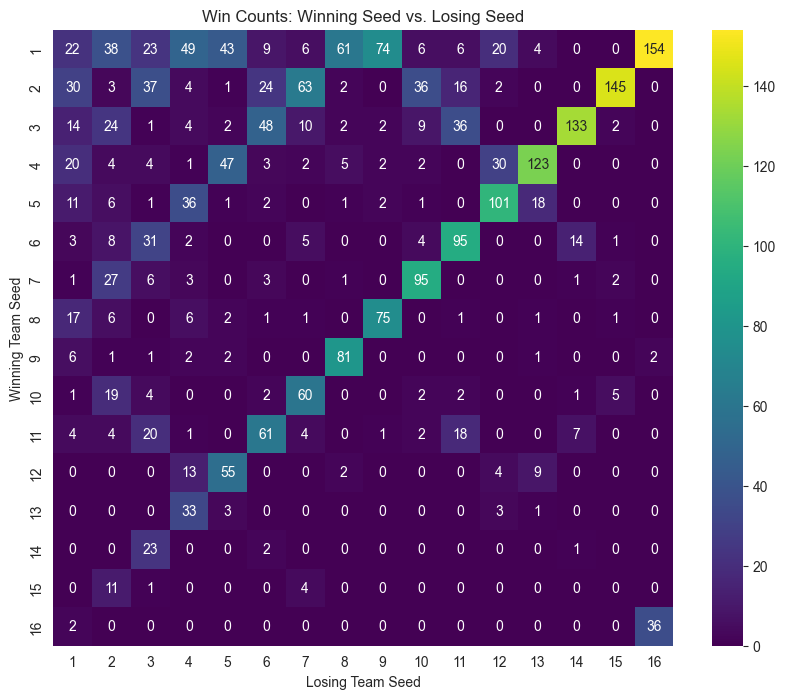

In [55]:
# Create the 16x16 matrix with seed values from 1 to 16
seed_matrix_all = pd.crosstab(TourneySeedResults['WTeamSeedRaw'], TourneySeedResults['LTeamSeedRaw'])
seeds = range(1, 17)
seed_matrix_all = seed_matrix_all.reindex(index=seeds, columns=seeds, fill_value=0)

# If you are in a Jupyter Notebook, simply display the styled DataFrame:
print("In tournament win count based on seed")

# Plot a heatmap with annotations
plt.figure(figsize=(10, 8))
sns.heatmap(seed_matrix_all, annot=True, fmt='d', cmap='viridis')
plt.title('Win Counts: Winning Seed vs. Losing Seed')
plt.xlabel('Losing Team Seed')
plt.ylabel('Winning Team Seed')
plt.show()

In tournament win count based on seed counted internally in region
Note: the diagonal entries are play-ins


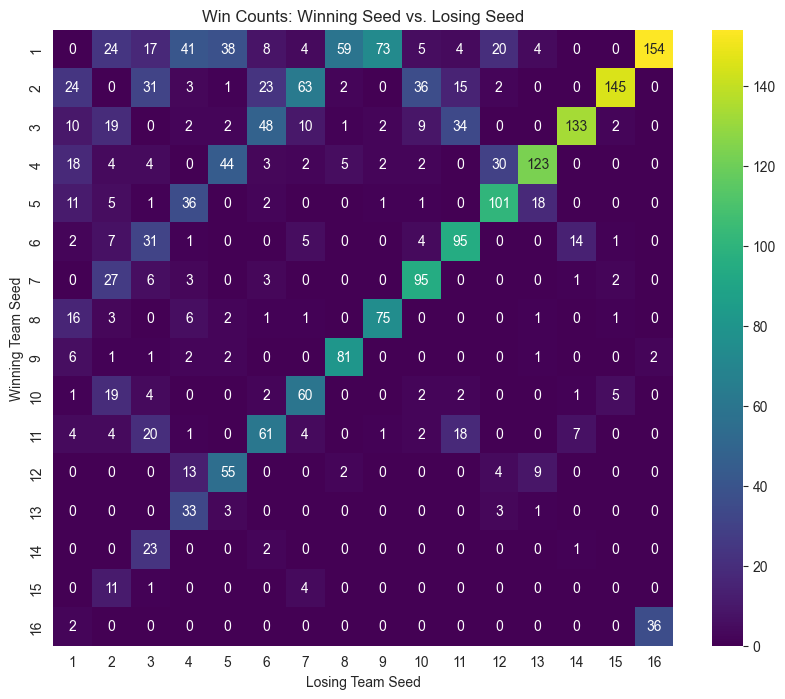

In [56]:
# Filter rows where WTeamSeed and LTeamSeed have different prefixes
filtered_results = TourneySeedResults[TourneySeedResults['WTeamSeedPrefix'] == TourneySeedResults['LTeamSeedPrefix']]

# Create the 16x16 matrix based on the filtered results
seed_matrix_region = pd.crosstab(filtered_results['WTeamSeedRaw'], filtered_results['LTeamSeedRaw'])

# Ensure the matrix includes all seeds from 1 to 16
seeds = range(1, 17)
seed_matrix_region = seed_matrix_region.reindex(index=seeds, columns=seeds, fill_value=0)

print("In tournament win count based on seed counted internally in region")
print("Note: the diagonal entries are play-ins")

# Plot a heatmap with annotations
plt.figure(figsize=(10, 8))
sns.heatmap(seed_matrix_region, annot=True, fmt='d', cmap='viridis')
plt.title('Win Counts: Winning Seed vs. Losing Seed')
plt.xlabel('Losing Team Seed')
plt.ylabel('Winning Team Seed')
plt.show()

In-tournament win count based on seed vs teams from other region
(so only the teams that got to the Final Four stage)


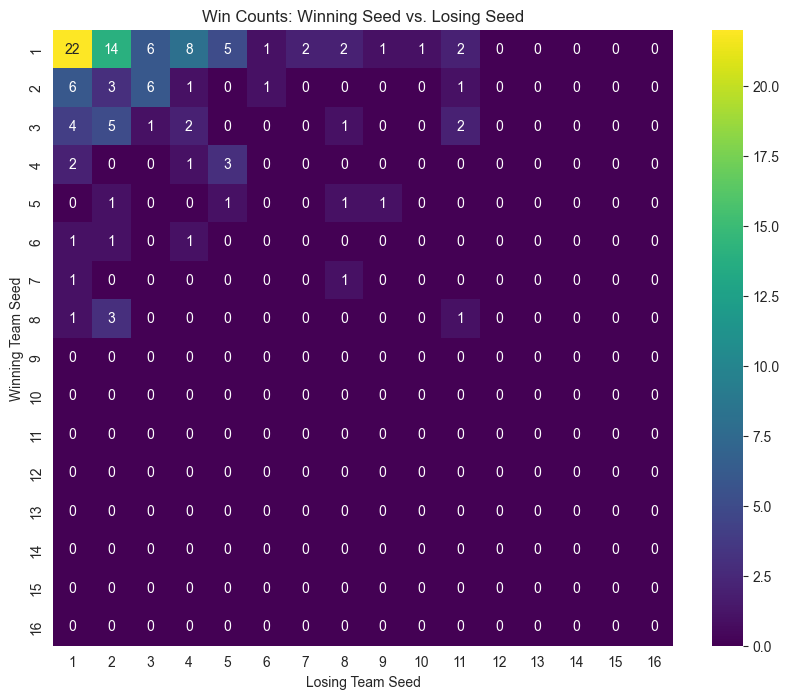

In [57]:
seed_matrix_external = seed_matrix_all - seed_matrix_region

# If you are in a Jupyter Notebook, simply display the styled DataFrame:
print("In-tournament win count based on seed vs teams from other region")
print("(so only the teams that got to the Final Four stage)")

# Plot a heatmap with annotations
plt.figure(figsize=(10, 8))
sns.heatmap(seed_matrix_external, annot=True, fmt='d', cmap='viridis')
plt.title('Win Counts: Winning Seed vs. Losing Seed')
plt.xlabel('Losing Team Seed')
plt.ylabel('Winning Team Seed')
plt.show()

Lower seeds (1 especially) get to the championship games (out of region).

Scores from tournament


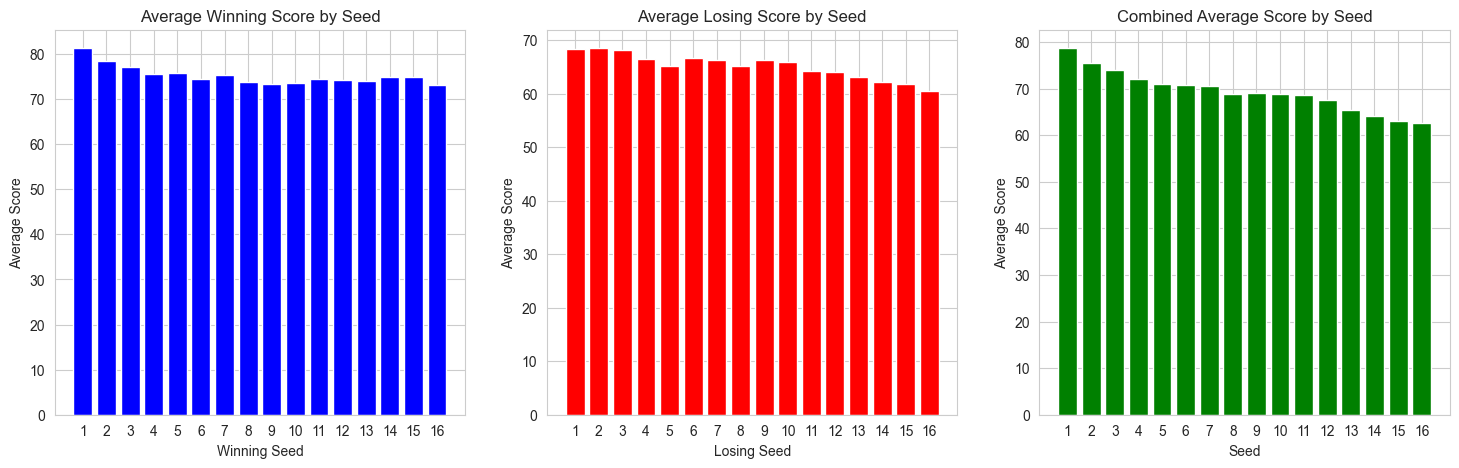

In [58]:
# Compute average score for winning teams grouped by winning seed
avg_win = TourneySeedResults.groupby('WTeamSeedRaw')['WScore'].mean().sort_index()

# Compute average score for losing teams grouped by losing seed
avg_loss = TourneySeedResults.groupby('LTeamSeedRaw')['LScore'].mean().sort_index()

# For combined average: combine winning and losing scores into one dataframe.
winning_scores = TourneySeedResults[['WTeamSeedRaw', 'WScore']].rename(columns={'WTeamSeedRaw':'Seed', 'WScore':'Score'})
losing_scores  = TourneySeedResults[['LTeamSeedRaw', 'LScore']].rename(columns={'LTeamSeedRaw':'Seed', 'LScore':'Score'})
combined_scores = pd.concat([winning_scores, losing_scores], ignore_index=True)

avg_combined = combined_scores.groupby('Seed')['Score'].mean().sort_index()

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Winning seeds only
axes[0].bar(avg_win.index, avg_win.values, color='blue')
axes[0].set_title('Average Winning Score by Seed')
axes[0].set_xlabel('Winning Seed')
axes[0].set_ylabel('Average Score')
axes[0].set_xticks(range(1, 17))

# Plot 2: Losing seeds only
axes[1].bar(avg_loss.index, avg_loss.values, color='red')
axes[1].set_title('Average Losing Score by Seed')
axes[1].set_xlabel('Losing Seed')
axes[1].set_ylabel('Average Score')
axes[1].set_xticks(range(1, 17))

# Plot 3: Combined seeds (winning + losing)
axes[2].bar(avg_combined.index, avg_combined.values, color='green')
axes[2].set_title('Combined Average Score by Seed')
axes[2].set_xlabel('Seed')
axes[2].set_ylabel('Average Score')
axes[2].set_xticks(range(1, 17))

print("Scores from tournament")
plt.show()

In [59]:
TourneySeedResults[TourneySeedResults['DayNum'] == 154].groupby('WTeamSeedRaw').size().reset_index(name='count')
# 154 is always the final day

,WTeamSeedRaw,count
0,1,25
1,2,5
2,3,4
3,4,2
4,6,1
5,7,1
6,8,1


So historically only the 8 best seeds have ever won and the lower seeds are very favoured in matchmaking.

### Team vs team win fraction

Performance in Tourney


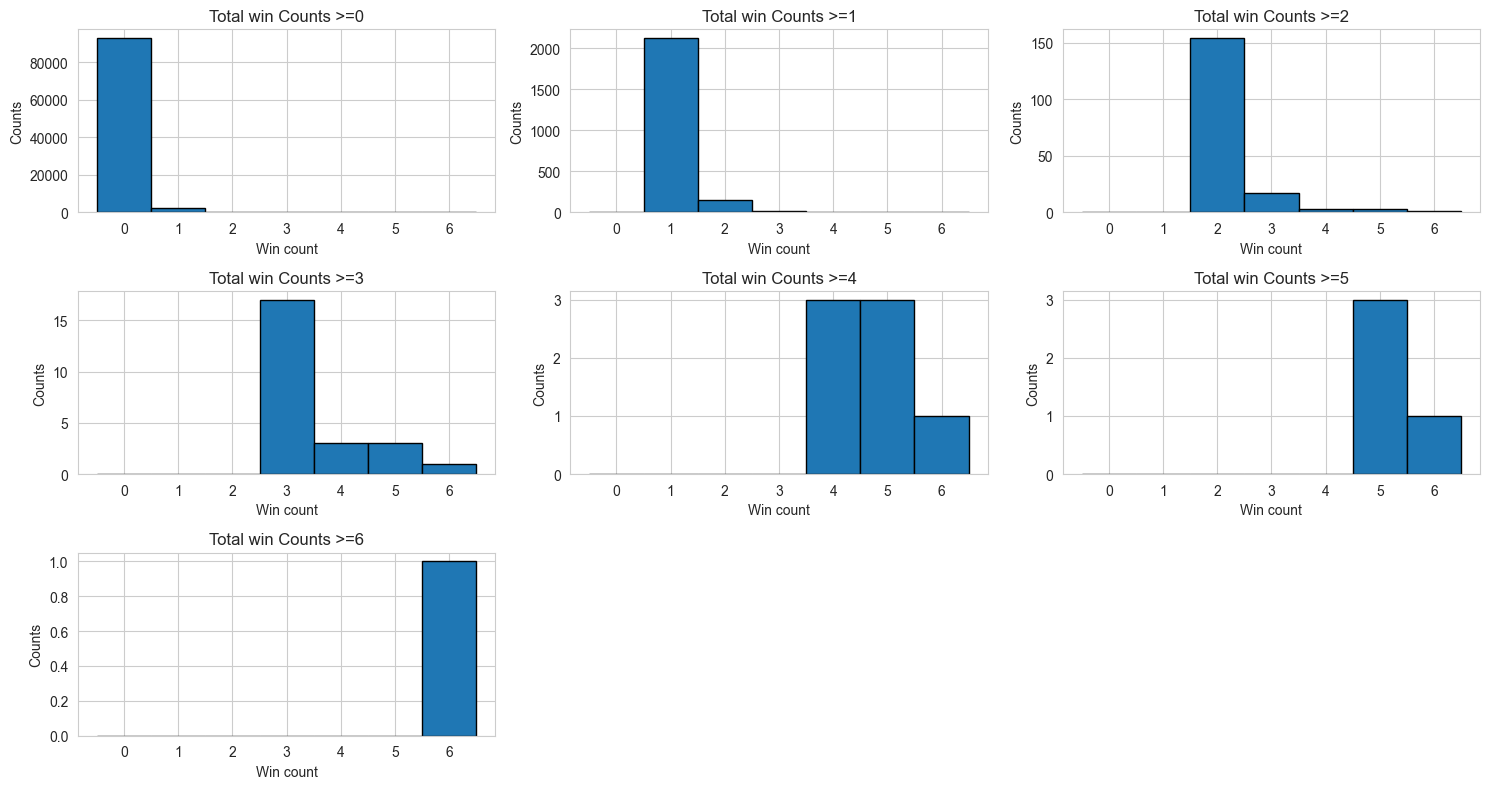

In [60]:
print('Performance in Tourney')

MTeamVsTeamWinCount = MNCAATourneyCompactResults.groupby(['WTeamID', 'LTeamID']).size().reset_index(name='count')
MTeamVsTeamWinCount = MTeamVsTeamWinCount.sort_values(by=['WTeamID', 'LTeamID'])

teams = pd.unique(MTeamVsTeamWinCount[['WTeamID', 'LTeamID']].values.ravel())
all_matchups = pd.DataFrame(itertools.product(teams, teams), columns=['WTeamID', 'LTeamID'])
all_matchups = all_matchups[all_matchups['WTeamID'] != all_matchups['LTeamID']]

MTeamVsTeamWinCount = all_matchups.merge(MTeamVsTeamWinCount, on=['WTeamID', 'LTeamID'], how='left').fillna(0)
MTeamVsTeamWinCount['count'] = MTeamVsTeamWinCount['count'].astype(int)
max_win_count = max(MTeamVsTeamWinCount['count'])

plt.figure(figsize=(15, 8))
for i in range(max_win_count + 1):
    tmp = MTeamVsTeamWinCount[MTeamVsTeamWinCount['count'] >= i]
    plt.subplot(math.ceil(max_win_count / 2),
                math.floor(max_win_count / 2 - 1) + 1,
                i + 1)
    bins = np.arange(max_win_count + 2) - 0.5 
    hist_values, bin_edges, _ = plt.hist(tmp['count'], bins=bins, edgecolor='black')
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.xticks(bin_centers, labels=[f"{x:.0f}" for x in bin_centers])
    plt.xlabel('Win count')
    plt.ylabel('Counts')
    plt.title(f'Total win Counts >={i}')

plt.tight_layout()
plt.show()

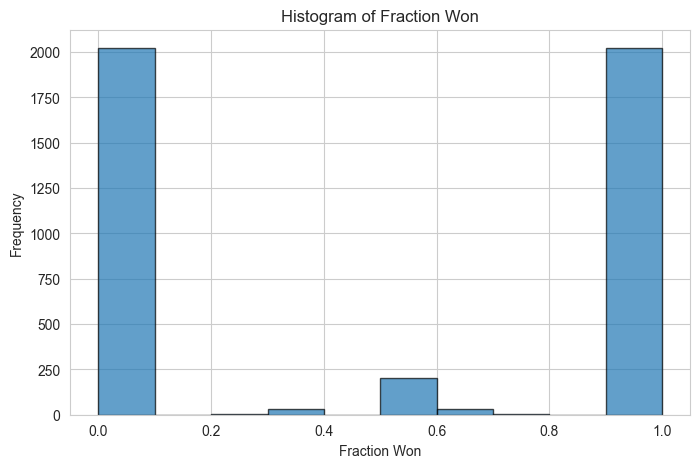

In [61]:
MTeamVsTeamWinCount["TeamPair"] = MTeamVsTeamWinCount.apply(lambda row: tuple(sorted([row["WTeamID"], row["LTeamID"]])), axis=1)

# Aggregate the total games played for each team pair
MTeamVsTeamWinCount["TotalGames"] = MTeamVsTeamWinCount.groupby("TeamPair")["count"].transform("sum")

# Drop the temporary TeamPair column if not needed
MTeamVsTeamWinCount = MTeamVsTeamWinCount.drop(columns=["TeamPair"])

MTeamVsTeamWinCount["FractionWon"] = MTeamVsTeamWinCount["count"] / MTeamVsTeamWinCount["TotalGames"]

MTeamVsTeamWinFraction = MTeamVsTeamWinCount[MTeamVsTeamWinCount["TotalGames"] > 0]

plt.figure(figsize=(8, 5))
plt.hist(MTeamVsTeamWinFraction["FractionWon"], bins=10, edgecolor='black', alpha=0.7)

# Labeling
plt.xlabel("Fraction Won")
plt.ylabel("Frequency")
plt.title("Histogram of Fraction Won")

# Show the plot
plt.show()

Performance in Regular Season
Max win count:  84


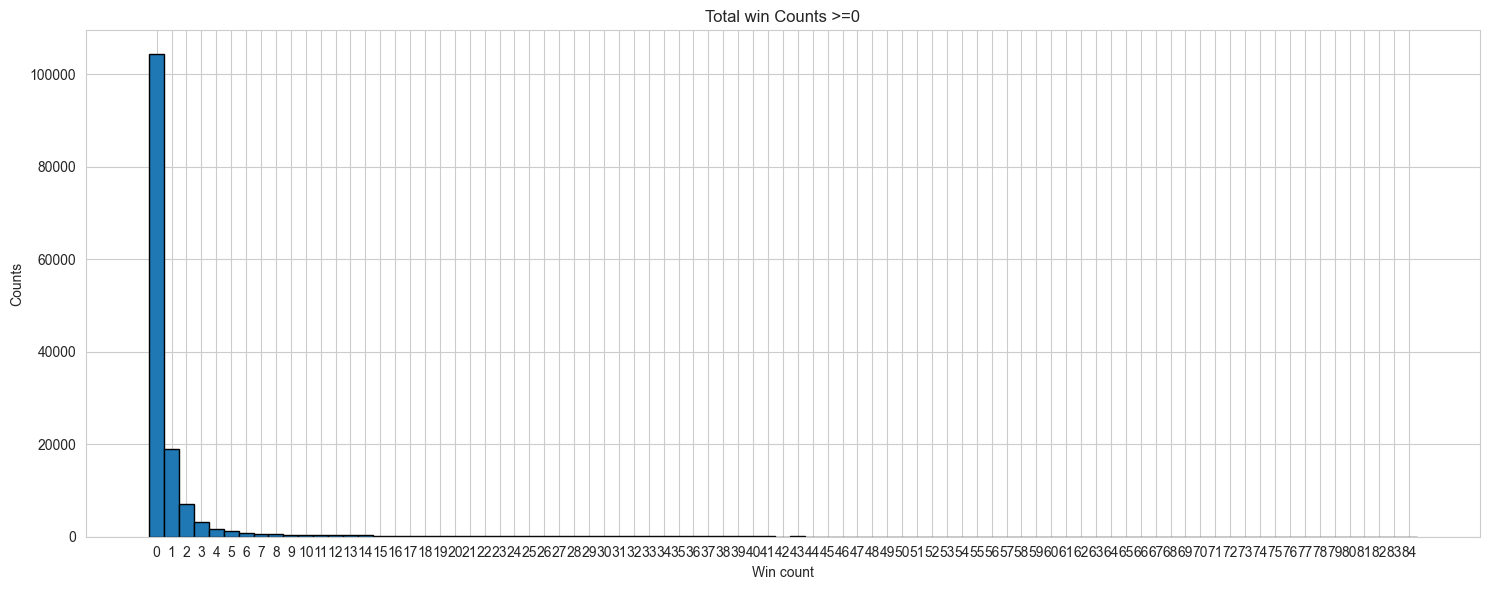

In [62]:
print('Performance in Regular Season')

MTeamVsTeamWinCount = MRegularSeasonCompactResults.groupby(['WTeamID', 'LTeamID']).size().reset_index(name='count')
MTeamVsTeamWinCount = MTeamVsTeamWinCount.sort_values(by=['WTeamID', 'LTeamID'])

teams = pd.unique(MTeamVsTeamWinCount[['WTeamID', 'LTeamID']].values.ravel())
all_matchups = pd.DataFrame(itertools.product(teams, teams), columns=['WTeamID', 'LTeamID'])
all_matchups = all_matchups[all_matchups['WTeamID'] != all_matchups['LTeamID']]

MTeamVsTeamWinCount = all_matchups.merge(MTeamVsTeamWinCount, on=['WTeamID', 'LTeamID'], how='left').fillna(0)
MTeamVsTeamWinCount['count'] = MTeamVsTeamWinCount['count'].astype(int)

max_win_count = max(MTeamVsTeamWinCount['count'])
print('Max win count: ', max_win_count)

# **Fix: Use plt.subplots()**
fig, axes = plt.subplots(1, 1, figsize=(15, 6))  # 1 row, 2 columns

tmp = MTeamVsTeamWinCount[MTeamVsTeamWinCount['count'] >= 0]
bins = np.arange(max_win_count + 2) - 0.5 
hist_values, bin_edges, _ = plt.hist(tmp['count'], bins=bins, edgecolor='black')
    
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.xticks(bin_centers, labels=[f"{x:.0f}" for x in bin_centers])

plt.xlabel('Win count')
plt.ylabel('Counts')
plt.title(f'Total win Counts >={0}')

plt.tight_layout()
plt.show()

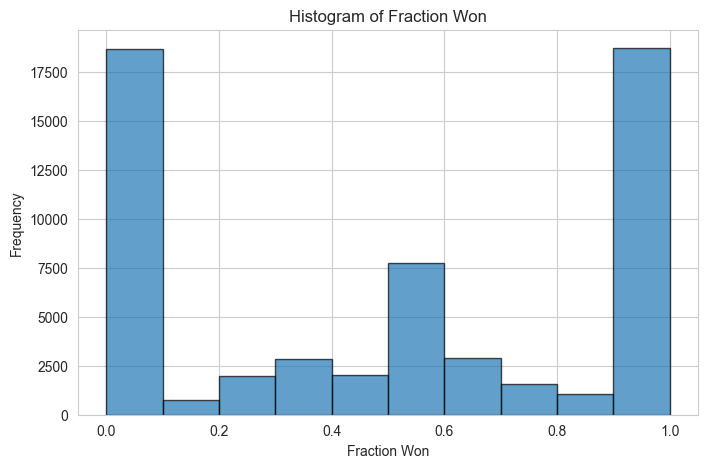

In [63]:
MTeamVsTeamWinCount["TeamPair"] = MTeamVsTeamWinCount.apply(lambda row: tuple(sorted([row["WTeamID"], row["LTeamID"]])), axis=1)

# Aggregate the total games played for each team pair
MTeamVsTeamWinCount["TotalGames"] = MTeamVsTeamWinCount.groupby("TeamPair")["count"].transform("sum")

# Drop the temporary TeamPair column if not needed
MTeamVsTeamWinCount = MTeamVsTeamWinCount.drop(columns=["TeamPair"])

MTeamVsTeamWinCount["FractionWon"] = MTeamVsTeamWinCount["count"] / MTeamVsTeamWinCount["TotalGames"]

MTeamVsTeamWinFraction = MTeamVsTeamWinCount[MTeamVsTeamWinCount["TotalGames"] > 0]

plt.figure(figsize=(8, 5))
plt.hist(MTeamVsTeamWinFraction["FractionWon"], bins=10, edgecolor='black', alpha=0.7)

# Labeling
plt.xlabel("Fraction Won")
plt.ylabel("Frequency")
plt.title("Histogram of Fraction Won")

# Show the plot
plt.show()

### How teams IDs are given

In [64]:
df = MTeams
print("Team IDs")
print('max number:', max(df['TeamID']))
print('min number:', min(df['TeamID']))
print('missng team numbers from sequence: ', sorted(set(range(min(df['TeamID']), max(df['TeamID'])+1)) - set(df['TeamID'])))

Team IDs
max number: 1480
min number: 1101
missng team numbers from sequence:  []


### How consistent are certain teams

In [65]:
df = MRegularSeasonDetailedResults

# --- Step 1. Identify the extra columns (from 'NumOT' onward) ---
cols = df.columns.tolist()
start_index = cols.index('NumOT')
extra_columns = cols[start_index:]
# extra_columns now holds the list of columns for which we want the mean

# --- Step 2. Aggregate winning and losing records separately ---

# For wins: group by Season and winning team (WTeamID)
wins_agg = df.groupby(['Season', 'WTeamID']).agg(
    wins_count=('WTeamID', 'size'),
    mean_winning_score=('WScore', 'mean')
).reset_index().rename(columns={'WTeamID': 'TeamID'})

# For losses: group by Season and losing team (LTeamID)
losses_agg = df.groupby(['Season', 'LTeamID']).agg(
    losses_count=('LTeamID', 'size'),
    mean_losing_score=('LScore', 'mean')
).reset_index().rename(columns={'LTeamID': 'TeamID'})

# --- Step 3. Overall game-level aggregation for the extra columns and overall mean score ---
# Create two dataframes—one for wins and one for losses—with the extra columns.
wins_extra = df[['Season', 'WTeamID'] + extra_columns].rename(columns={'WTeamID': 'TeamID'})
losses_extra = df[['Season', 'LTeamID'] + extra_columns].rename(columns={'LTeamID': 'TeamID'})

# Combine both so that each game appears once per team
all_extra = pd.concat([wins_extra, losses_extra], ignore_index=True)
overall_extra = all_extra.groupby(['Season', 'TeamID']).mean().reset_index()

# For the overall score, combine the scores from wins and losses.
wins_score = df[['Season', 'WTeamID', 'WScore']].rename(
    columns={'WTeamID': 'TeamID', 'WScore': 'Score'}
)
losses_score = df[['Season', 'LTeamID', 'LScore']].rename(
    columns={'LTeamID': 'TeamID', 'LScore': 'Score'}
)
all_scores = pd.concat([wins_score, losses_score], ignore_index=True)
overall_scores = all_scores.groupby(['Season', 'TeamID']).agg(
    total_score_sum=('Score', 'sum'),
    total_games=('Score', 'size')
).reset_index()
overall_scores['mean_score'] = overall_scores['total_score_sum'] / overall_scores['total_games']

# --- Step 4. Merge the wins and losses aggregates ---
agg = pd.merge(wins_agg, losses_agg, on=['Season', 'TeamID'], how='outer')

# Fill missing win/loss counts with 0 (teams that only lost or only won)
agg['wins_count'] = agg['wins_count'].fillna(0)
agg['losses_count'] = agg['losses_count'].fillna(0)
agg['total_games'] = agg['wins_count'] + agg['losses_count']

# Compute fractions for wins and losses
agg['fraction_wins'] = agg['wins_count'] / agg['total_games']
agg['fraction_losses'] = agg['losses_count'] / agg['total_games']

# --- Step 5. Merge overall score and extra columns ---
agg = pd.merge(agg, overall_scores[['Season', 'TeamID', 'mean_score']], on=['Season', 'TeamID'], how='outer')
final_df = pd.merge(agg, overall_extra, on=['Season', 'TeamID'], how='outer')

# --- Step 6. Rearrange columns in the desired order ---
final_df = final_df[['Season', 'TeamID', 'fraction_wins', 'fraction_losses', 
                     'mean_winning_score', 'mean_losing_score', 'mean_score'] + extra_columns]

print('fraction of wins / losses, means of other parameters')
# Display the resulting dataframe
final_df.head()

fraction of wins / losses, means of other parameters


,Season,TeamID,fraction_wins,fraction_losses,mean_winning_score,mean_losing_score,mean_score,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,1102,0.428571,0.571429,68.750000,48.625000,57.250000,0.000000,20.821429,39.571429,...,17.642857,9.785714,14.428571,7.071429,16.250000,9.035714,12.750000,5.357143,0.964286,20.535714
1,2003,1103,0.481481,0.518519,87.769231,70.428571,78.777778,0.296296,28.962963,54.777778,...,18.962963,16.444444,22.148148,11.703704,19.259259,13.296296,14.296296,6.851852,2.629630,22.074074
2,2003,1104,0.607143,0.392857,74.705882,60.909091,69.285714,0.035714,25.500000,56.000000,...,19.178571,11.928571,16.821429,12.178571,21.785714,10.178571,14.535714,5.357143,2.785714,20.321429
3,2003,1105,0.269231,0.730769,79.428571,68.947368,71.769231,0.153846,27.692308,60.115385,...,19.423077,14.576923,21.269231,13.115385,22.500000,13.615385,19.730769,8.192308,2.615385,20.384615
4,2003,1106,0.464286,0.535714,68.307692,59.533333,63.607143,0.035714,24.500000,53.321429,...,16.750000,12.250000,17.607143,11.678571,19.964286,9.928571,16.214286,8.035714,2.535714,18.071429


In [66]:
# Step 1: Identify extra columns starting from 'NumOT'
cols = MRegularSeasonCompactResults.columns.tolist()
start_index = cols.index('NumOT')
extra_columns = cols[start_index:]

# Step 2: Create a long-form DataFrame from raw game data for wins and losses
wins_df = MRegularSeasonCompactResults[['Season', 'WTeamID', 'WScore'] + extra_columns].copy()
wins_df = wins_df.rename(columns={'WTeamID': 'TeamID', 'WScore': 'Score'})
wins_df['win_flag'] = 1

losses_df = MRegularSeasonCompactResults[['Season', 'LTeamID', 'LScore'] + extra_columns].copy()
losses_df = losses_df.rename(columns={'LTeamID': 'TeamID', 'LScore': 'Score'})
losses_df['win_flag'] = 0

# Concatenate wins and losses into a single DataFrame
long_df = pd.concat([wins_df, losses_df], ignore_index=True)

# Step 3: Compute standard deviation on raw game data for each team (ignoring Season)

# Overall standard deviation of the score (from all games)
std_total_score = long_df.groupby('TeamID')['Score'].std().reset_index().rename(columns={'Score': 'std_total_score'})

# Standard deviation of win indicator (binary: 1 for win, 0 for loss)
std_win_flag = long_df.groupby('TeamID')['win_flag'].std().reset_index().rename(columns={'win_flag': 'std_win_flag'})

# Standard deviation of winning scores (only on wins)
std_winning_score = wins_df.groupby('TeamID')['Score'].std().reset_index().rename(columns={'Score': 'std_winning_score'})

# Standard deviation of losing scores (only on losses)
std_losing_score = losses_df.groupby('TeamID')['Score'].std().reset_index().rename(columns={'Score': 'std_losing_score'})

# Standard deviations for the extra columns (from 'NumOT' onward) across all games
std_extra = long_df.groupby('TeamID')[extra_columns].std().reset_index()

# Merge all standard deviation calculations on TeamID (ignoring Season)
raw_std_in_seasonstd_df = std_total_score.merge(std_win_flag, on='TeamID', how='outer') \
    .merge(std_winning_score, on='TeamID', how='outer') \
    .merge(std_losing_score, on='TeamID', how='outer') \
    .merge(std_extra, on='TeamID', how='outer')

print('std of raw values')
# raw_std_df now contains TeamID and the standard deviations of the raw data metrics.
raw_std_in_seasonstd_df.head()

std of raw values


,TeamID,std_total_score,std_win_flag,std_winning_score,std_losing_score,NumOT
0,1101,11.931218,0.499884,8.113678,11.495789,0.320089
1,1102,12.136450,0.479471,11.850982,10.335667,0.243537
2,1103,12.291633,0.492515,10.857103,10.825376,0.266008
3,1104,13.056490,0.482602,12.450349,10.200421,0.285332
4,1105,12.391173,0.476859,11.048283,10.594939,0.328072


In [67]:
# Group by TeamID and compute standard deviation (ignoring Season)
std_mean_season = final_df.groupby('TeamID').std().reset_index()

# Rename the columns to indicate standard deviation
std_mean_season = std_mean_season.rename(columns={col: f"{col}_std" for col in std_mean_season.columns if col != 'TeamID'})

print("std of the mean per season, std of fraction of wins / losses")
std_mean_season.head()

std of the mean per season, std of fraction of wins / losses


,TeamID,Season_std,fraction_wins_std,fraction_losses_std,mean_winning_score_std,mean_losing_score_std,mean_score_std,NumOT_std,WFGM_std,WFGA_std,...,LFGA3_std,LFTM_std,LFTA_std,LOR_std,LDR_std,LAst_std,LTO_std,LStl_std,LBlk_std,LPF_std
0,1101,3.605551,0.217339,0.217339,1.914375,3.406443,4.291418,0.060886,0.643919,2.249740,...,1.580100,2.048921,2.401151,0.797662,1.578799,1.156071,1.919112,0.903986,0.655485,1.100463
1,1102,6.782330,0.171020,0.171020,5.345238,5.488994,4.765477,0.040691,2.296467,5.015475,...,2.573523,1.290292,1.943482,1.295292,2.412251,1.441913,1.059460,0.520334,0.585501,1.156608
2,1103,6.782330,0.108017,0.108017,4.423857,3.716268,3.960763,0.068028,1.690424,2.763002,...,2.827639,1.471371,1.797817,1.754076,1.630498,1.284712,1.578124,0.776327,0.349569,1.195069
3,1104,6.782330,0.111773,0.111773,7.842676,5.992397,7.612614,0.048904,2.434801,4.189885,...,3.354974,1.752719,2.295525,1.261851,1.282855,1.108919,1.170794,0.887826,0.541961,1.262122
4,1105,6.782330,0.120680,0.120680,4.724295,4.306932,4.220983,0.051831,1.501945,2.423329,...,2.020248,2.066282,2.869323,1.792859,1.535935,1.150972,2.135773,1.366206,1.040784,1.605426


### How many years back are results consistent

Average autocorrelation for 'fraction_wins' by lag:
Lag 1: 0.280
Lag 2: 0.098
Lag 3: -0.022
Lag 4: -0.035
Lag 5: -0.035


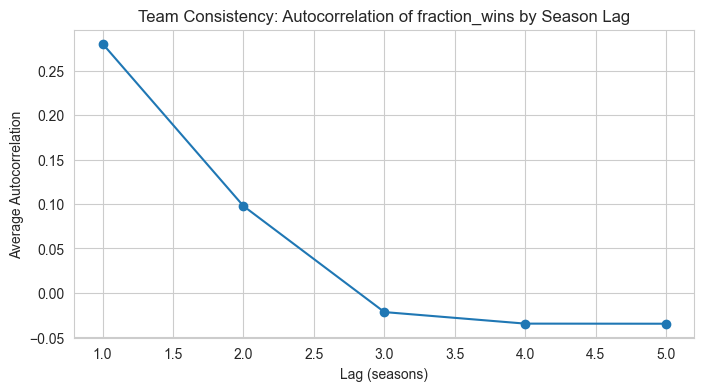

Based on a threshold of 0.2, results are consistent up to 1 season(s) back.


In [68]:
def compute_autocorrelations(df, metric, max_lag):
    """
    Compute the average autocorrelation for a given metric over different lags.
    
    Parameters:
        df (DataFrame): DataFrame with season-level team data.
        metric (str): The column name to compute autocorrelation on.
        max_lag (int): Maximum lag (in seasons) to compute.
        
    Returns:
        dict: Dictionary mapping lag -> average autocorrelation (across teams).
    """
    autocorr_by_lag = {}
    teams = df['TeamID'].unique()
    for lag in range(1, max_lag+1):
        ac_list = []
        for team in teams:
            team_data = df[df['TeamID'] == team].sort_values('Season')
            if len(team_data) > lag:
                ac = team_data[metric].autocorr(lag=lag)
                if not np.isnan(ac):
                    ac_list.append(ac)
        # Average the autocorrelations for this lag across teams
        autocorr_by_lag[lag] = np.mean(ac_list) if ac_list else np.nan
    return autocorr_by_lag

df = final_df # from 1st cell previous section

# Determine the maximum lag to consider: e.g. the smallest maximum number of seasons available among teams or a fixed number.
max_possible_lag = df.groupby('TeamID')['Season'].count().max() - 1
max_lag = min(5, max_possible_lag) if max_possible_lag >= 1 else 1

# Compute average autocorrelations for the 'fraction_wins' metric.
avg_ac = compute_autocorrelations(df, 'fraction_wins', max_lag)

print("Average autocorrelation for 'fraction_wins' by lag:")
for lag, ac in avg_ac.items():
    print(f"Lag {lag}: {ac:.3f}")

# Plot the average autocorrelation vs. lag.
lags = list(avg_ac.keys())
ac_values = list(avg_ac.values())

plt.figure(figsize=(8, 4))
plt.plot(lags, ac_values, marker='o')
plt.xlabel("Lag (seasons)")
plt.ylabel("Average Autocorrelation")
plt.title("Team Consistency: Autocorrelation of fraction_wins by Season Lag")
plt.grid(True)
plt.show()

# Determine up to how many seasons back results are consistent.
# For example, we can say results are consistent if the average autocorrelation is above a threshold.
threshold = 0.2
consistent_lags = [lag for lag, ac in avg_ac.items() if ac >= threshold]
max_consistent = max(consistent_lags) if consistent_lags else 0

print(f"Based on a threshold of {threshold}, results are consistent up to {max_consistent} season(s) back.")


Obviously the college teams change rapidly. The highest autocorrelation is one season back, no surprises here.

## INITIAL MODELS

In [69]:
games = pd.read_csv('../../data/MRegularSeasonCompactResults.csv')
games['TeamA'] = games[['WTeamID', 'LTeamID']].min(axis=1)
games['TeamB'] = games[['WTeamID', 'LTeamID']].max(axis=1)
def split_train_test_by_pair(games_df, n=1):
    train_list = []
    test_list = []

    grouped = games_df.groupby(['TeamA', 'TeamB'])

    for (teamA, teamB), group in grouped:
        group_sorted = group.sort_values(['Season', 'DayNum'])
        if len(group_sorted) > n:
            train = group_sorted.iloc[:-n]
            test = group_sorted.iloc[-n:]
        else:
            train = group_sorted.iloc[0:0]
            test = group_sorted

        train_list.append(train)
        test_list.append(test)

    train_set = pd.concat(train_list).reset_index(drop=True)
    test_set = pd.concat(test_list).reset_index(drop=True)

    return train_set, test_set

n = 1

train_set, test_set = split_train_test_by_pair(games, n=n)

print("Train set shape:", train_set.shape)
print("Test set shape:", test_set.shape)
print(test_set.head())

Train set shape: (162629, 10)
Test set shape: (29167, 10)
   Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT  TeamA  TeamB
0    2018      37     1101      62     1102      58    A      0   1101   1102
1    2015      50     1101      69     1115      61    N      0   1101   1115
2    2024      45     1116      83     1101      73    H      0   1101   1116
3    2019       4     1101      94     1117      73    H      0   1101   1117
4    2021      25     1101      80     1122      72    N      0   1101   1122


In [70]:
n = 1
train_set, test_set = split_train_test_by_pair(games, n=n)

print("Train set shape:", train_set.shape)
print("Test set shape:", test_set.shape)

def create_features(df):
    df = df.copy()
    df['Outcome'] = (df['WTeamID'] == df['TeamA']).astype(int)
    X = df[['TeamA', 'TeamB']].astype(str)
    y = df['Outcome']
    X_encoded = pd.get_dummies(X, columns=['TeamA', 'TeamB'])
    return X_encoded, y

X_train, y_train = create_features(train_set)
X_test, y_test = create_features(test_set)

X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

models = {
    'XGBoost (CPU)': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM (CPU)': lgb.LGBMClassifier(),
    'Logistic Regression (CPU)': LogisticRegression(max_iter=1000),
}

bootstrap_threshold = 200
bootstrap_factor = 3

progress = widgets.IntProgress(value=0, min=0, max=len(models), description='Models:')
display(progress)

results = {}

for name, model in models.items():
    if len(X_train) < bootstrap_threshold:
        X_train_boot = X_train.sample(n=bootstrap_factor * len(X_train), replace=True, random_state=42)
        y_train_boot = y_train.loc[X_train_boot.index]
        X_to_train = X_train_boot
        y_to_train = y_train_boot
    else:
        X_to_train = X_train
        y_to_train = y_train

    start_time = time.time()
    model.fit(X_to_train, y_to_train)
    training_time = time.time() - start_time

    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = model.decision_function(X_test)
        y_pred_proba = 1 / (1 + np.exp(-y_pred_proba))

    brier = brier_score_loss(y_test, y_pred_proba)

    results[name] = {
        'model': model,
        'training_time': training_time,
        'brier_score': brier,
        'y_pred_proba': y_pred_proba
    }

    progress.value += 1

progress.layout.visibility = 'hidden'

print("Trained models and their performance on the test set:")
for name, res in results.items():
    print(f"{name} - Training time: {res['training_time']:.2f} sec, Brier Score: {res['brier_score']:.4f}")


Train set shape: (162629, 10)
Test set shape: (29167, 10)


IntProgress(value=0, description='Models:', max=3)

[LightGBM] [Info] Number of positive: 79752, number of negative: 82877
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1408
[LightGBM] [Info] Number of data points in the train set: 162629, number of used features: 704
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.490392 -> initscore=-0.038436
[LightGBM] [Info] Start training from score -0.038436
Trained models and their performance on the test set:
XGBoost (CPU) - Training time: 3.49 sec, Brier Score: 0.2166
LightGBM (CPU) - Training time: 1.18 sec, Brier Score: 0.2089
Logistic Regression (CPU) - Training time: 2.18 sec, Brier Score: 0.1754
